In [ ]:
# -*- coding: utf-8 -*-
"""
Created on 2023/04/11
Revised on 2023/05/30
 
@author: mjofre - Marc Jofre
e-mail: marc.jofre@upc.edu
Technical University of Catalonia - Universitat Politècnica de Catalunya (UPC)
"""
###########################################################################
# Seminar on Quantum Technologies for Cybersecurity: Networking and Systems
# Self-study
# Session 3 - Key building blocks

import os, sys, time
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.style
import matplotlib as mpl
#print(plt.style.available)
mpl.style.use('default')

try:  
  import qiskit
except:
  print("installing qiskit...")
  !pip install qiskit --quiet
  print("installed qiskit.")
  import qiskit


# Self-study (5 hours):

Read on Quantum Key Distribution (2 hours):
 - https://arxiv.org/pdf/quant-ph/0101098.pdf
 - https://arxiv.org/pdf/0802.4155.pdf
 - https://arxiv.org/pdf/2108.13642.pdf
 - https://arxiv.org/pdf/1703.09278.pdf
 - https://www.nature.com/articles/npjqi201625.pdf
 
Read on quantum teleportation basics (1 hour):
 - https://tu-delft.foleon.com/tu-delft/quantum-internet/quantum-teleportation/
 - https://quantumatlas.umd.edu/entry/teleportation/

Exercises on quantum key distribution and teleportation (2 hours). 


# Definition of Transmission calculations for Quantum Key distribution
# Just run this cell

In [ ]:
def TransmissionBB84DecoyStateComputeSKRcontinuousphase(SourcePulseRate,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,SystemDetectorPerformanceArray,DVQKDprotocol):
    # H.-K. Lo, X. Ma, and K. Chen, “Decoy State Quantum Key Distribution,” Phys. Rev. Lett., vol. 94, no. 23, p. 230504, Jun. 2005, doi: 10.1103/PhysRevLett.94.230504.    
    RateAlice=SourcePulseRate
    try:
      Nlen=len(AttenuationdBforDistance)
    except:
      Nlen=1
    alphaLink=0.1 # 0.1 dB/Km link loss free-space attenuation#0.2dB/Km for 1550nm telecom fiber
    Distance=AttenuationdBforDistance/alphaLink*1000.0#np.linspace(0,350000,len(Measured_EMu))
    #Distance_plot=Distance*1e-3
    
    Y0=SystemDetectorPerformanceArray[0]
    e0=SystemDetectorPerformanceArray[1]
    transmittanceBob=SystemDetectorPerformanceArray[2]
    attDetectors=SystemDetectorPerformanceArray[3]

    MuRate=DecoyStatesRates[0] # Rate of signal states sent
    Nu1Rate=DecoyStatesRates[1] # Rate of decoy 1 states sent
    Nu2Rate=DecoyStatesRates[2] # Rate of decoy 2 states sent
    
    if ((MuRate+Nu1Rate+Nu2Rate)!=1.0):
        print('MuRate+Nu1Rate+Nu2Rate: '+str(MuRate+Nu1Rate+Nu2Rate))
        print('Error in the settings rates of the signal and decoy rates (MuRate+Nu1Rate+Nu2Rate)!=1.0')
        return
    
    fe=1.16 # bidirectional error correction factor
    
    Mu=DecoyStatesPhotPulse[0]#0.5
    Nu1=DecoyStatesPhotPulse[1]#Mu*np.power(10,(-4.65/10.0))
    Nu2=DecoyStatesPhotPulse[2]#Mu*np.power(10,(-14.76/10.0))
    
    attLink=np.power(10,(-(alphaLink/10.0)*(Distance/1000.0))) # Channel transmittance
    attBob=attDetectors*transmittanceBob # denote the transmittance in Bob's side: internal transmittance of optical components and detector efficiency
    att=attLink*attBob#*(1-1/50); # Overall transmission and detection efficiency between Alice and Bob
    
    RateOutputAlice_signal=RateAlice*Mu # Rate of signals states sent out by Alice
    RKR_plot=RateOutputAlice_signal*att # RKR due to signal states
    
    # Yield of a i-photon pulse
    Y1 = Y0+(1-(1-att)**1)
    Y2 = Y0+(1-(1-att)**2)
    
    # Fung, C.-H.F., Tamaki, K., Lo, H.-K.: Performance of two quantum-key-distribution protocols. Phys. Rev. A 73(1), 012337 (2006)
    # Ma, X., Qi, B., Zhao, Y., Lo, H.-K.: Practical decoy state for quantum key distribution. Phys. Rev. A 72(1), 012326 (2005)
    # Gain of states
    QMu = Y0+1-np.exp(-att*Mu) # Gain of the signal state. Equivalent to Y0 if Mu=0
    QNu1 = Y0+1-np.exp(-att*Nu1) # Gain of the decoy state. Equivalent to Y0 if Nu1=0
    QNu2 = Y0+1-np.exp(-att*Nu2) # Gain of the vacuum state. Equivalent to Y0 if Nu2=0

    edetector=0#1.0-cos(atan(0.05))**2#0.01; # Probability that a photon hits the wrong detector. It has to due with misalignment and finite PER of polarization splitters
    EMu = (e0*Y0+edetector*(1-np.exp(-att*Mu)))/QMu # QBER for the signal state
    ENu1 = (e0*Y0+edetector*(1-np.exp(-att*Nu1)))/QNu1 # QBER for the decoy state
    ENu2=np.zeros_like(ENu1)
    if (np.sum(QNu2<=0.0)>1):
      ENu2[QNu2<=0.0] = 0.5 # QBER for the vacuum state
      ENu2[QNu2>0.0] = (e0*Y0+edetector*(1-np.exp(-att[QNu2>0.0]*Nu2)))/QNu2[QNu2>0.0] # QBER for the vacuum state
    else:
      ENu2 = (e0*Y0+edetector*(1-np.exp(-att*Nu2)))/QNu2 # QBER for the vacuum state
        
    ## Computations theoretical
    #print('Nu1: '+str(Nu1))
    #print('Nu2: '+str(Nu2))
    #print('QNu1: '+str(QNu1))
    #print('QNu2: '+str(QNu2))
    
    Y0LowerBound = (Nu1*QNu2*np.exp(Nu2)-Nu2*QNu1*np.exp(Nu1))/(Nu1-Nu2) # Yield.
    if (np.sum(Y0LowerBound<0.0)>0):
        Y0LowerBound[Y0LowerBound<0.0]=0.0
    
    Y1LowerBound = (np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield of single photon pulses
    if (np.sum(Y1LowerBound<0.0)>0):
        Y1LowerBound[Y1LowerBound<0.0]=0.0
    
    Y2LowerBound = Y2# approx #(np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield of two-photon pulses
    if (np.sum(Y2LowerBound<0.0)>0):
        Y2LowerBound[Y2LowerBound<0.0]=0.0
    
    Q0LowerBound = Mu*np.exp(-Mu)*Y0LowerBound # Gain of the vacuum-photon pulses.    
    Q1LowerBound = Mu*np.exp(-Mu)*Y1LowerBound # Gain of the single photon pulses.
    Q2LowerBound = ((Mu**2)/2)*np.exp(-Mu)*Y2LowerBound # Gain of the two-photon pulses. # # Ma, X., Qi, B., Zhao, Y., Lo, H.-K.: Practical decoy state for quantum key distribution. Phys. Rev. A 72(1), 012326 (2005)

    e0Bound=e0*np.ones((int(len(Y0LowerBound))),dtype=np.float32)
    e1UpperBound = (EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q1LowerBound*np.exp(Mu)) # Error rate of single photon pulses
    e2UpperBound = (EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu))#1-(1-(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu)))**2 # Error rate of two-photon pulses
    
    if (np.sum(e1UpperBound<0.0)>0):
        e1UpperBound[e1UpperBound<0.0]=0.0
    
    if (np.sum(e1UpperBound>1.0)>0):
        e1UpperBound[e1UpperBound>1.0]=1.0
    
    if (np.sum(e2UpperBound<0.0)>0):
        e2UpperBound[e2UpperBound<0.0]=0.0
    
    if (np.sum(e2UpperBound>1.0)>0):
        e2UpperBound[e2UpperBound>1.0]=1.0
    
    QBER=e1UpperBound # QBER due only to single-photon. In general the bit error ratio of n-photon signals being e_n=Y_0/(2*Y_n)
    
    H2EMu=np.zeros(int(len(EMu)),dtype=np.float32)
    for iIter in range(0,len(EMu),1):
        if (EMu[iIter]<=0.0):
            H2EMu[iIter]=0.0
        else:
            H2EMu[iIter] = -EMu[iIter]*np.log2(EMu[iIter])-(1.0-EMu[iIter])*np.log2(1.0-EMu[iIter])
    
    H2e0Upper=np.zeros(int(len(e0Bound)),dtype=np.float32)
    for iIter in range(0,len(e0Bound),1):
        if ((e0Bound[iIter]<=0.0) or (e0Bound[iIter]>=1.0)):
            H2e0Upper[iIter]=0.0
        else:
            H2e0Upper[iIter] = -e0Bound[iIter]*np.log2(e0Bound[iIter])-(1.0-e0Bound[iIter])*np.log2(1.0-e0Bound[iIter])
    
    H2e1Upper=np.zeros(int(len(e1UpperBound)),dtype=np.float32)
    for iIter in range(0,len(e1UpperBound),1):
        if ((e1UpperBound[iIter]<=0.0) or (e1UpperBound[iIter]>=1.0)):
            H2e1Upper[iIter]=0.0
        else:
            H2e1Upper[iIter] = -e1UpperBound[iIter]*np.log2(e1UpperBound[iIter])-(1.0-e1UpperBound[iIter])*np.log2(1.0-e1UpperBound[iIter])
    
    H2e2Upper=np.zeros(int(len(e2UpperBound)),dtype=np.float32)
    for iIter in range(0,len(e2UpperBound),1):
        if ((e2UpperBound[iIter]<=0.0) or (e2UpperBound[iIter]>=1.0)):
            H2e2Upper[iIter]=0.0
        else:
            H2e2Upper[iIter] = -e2UpperBound[iIter]*np.log2(e2UpperBound[iIter])-(1.0-e2UpperBound[iIter])*np.log2(1.0-e2UpperBound[iIter])
    
    # Lower Secure Key Rate
    if (DVQKDprotocol=='SARG04+decoy'): # One-photon and 2-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.25 # For SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper)+Q2LowerBound*(1.0-H2e2Upper))*RateOutputAlice_signal
    else: # for instance 'BB84+decoy' only one-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.5 # For BB84 it is 0.5; for SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal#CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q0LowerBound*(1.0-H2e0Upper) + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal
    
    if (np.sum(KeyBitRateLowerBond<0.0)>0):
        KeyBitRateLowerBond[KeyBitRateLowerBond<0.0]=0.0
        
    # Remove glitches
    for iIter in range(1,int(Nlen-2),1):
        if (np.logical_and(KeyBitRateLowerBond[iIter-1]<=0.0,KeyBitRateLowerBond[iIter+1]<=0.0) or np.logical_and(KeyBitRateLowerBond[iIter-2]<=0.0,KeyBitRateLowerBond[iIter+2]<=0.0)):
            KeyBitRateLowerBond[iIter]=0.0
    
    if (np.sum(KeyBitRateLowerBond<=0.0)>0):
        QBER[KeyBitRateLowerBond<=0.0]=0.5
    
    if (np.sum(QBER>=0.5)>0): # Not to be displayed in the image
        QBER[QBER>=0.5]=0.0
        
    return attLink,RKR_plot,KeyBitRateLowerBond,QBER

def TransmissionBB84DecoyStateComputeSKRdiscretephase(SourcePulseRate,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,Nphases,SystemDetectorPerformanceArray,DVQKDprotocol):
    Nphases=int(np.min([16,np.max([1.0,Nphases])]))
    NphasesValue=np.linspace(0,2*np.pi,Nphases) # Nphases different values each with probability 1/Nphases over [0, 2*np.pi)]
    try:
      Nlen=len(AttenuationdBforDistance)
    except:
      Nlen=1
    RateAlice=SourcePulseRate
    alphaLink=0.1 # 0.1 dB/Km link loss free-space attenuation#0.2dB/Km for 1550nm telecom fiber
    Distance=AttenuationdBforDistance/alphaLink*1000.0#np.linspace(0,350000,len(Measured_EMu))
    #Distance_plot=Distance*1e-3

    Y0=SystemDetectorPerformanceArray[0]
    e0=SystemDetectorPerformanceArray[1]
    transmittanceBob=SystemDetectorPerformanceArray[2]
    attDetectors=SystemDetectorPerformanceArray[3]
    
    MuRate=DecoyStatesRates[0] # Rate of signal states sent
    Nu1Rate=DecoyStatesRates[1] # Rate of decoy 1 states sent
    Nu2Rate=DecoyStatesRates[2] # Rate of decoy 2 states sent
    
    if ((MuRate+Nu1Rate+Nu2Rate)!=1.0):
        print('MuRate+Nu1Rate+Nu2Rate: '+str(MuRate+Nu1Rate+Nu2Rate))
        print('Error in the settings rates of the signal and decoy rates (MuRate+Nu1Rate+Nu2Rate)!=1.0')
        return
    
    fe=1.16 # bidirectional error correction factor
    
    Mu=DecoyStatesPhotPulse[0]#0.5
    Nu1=DecoyStatesPhotPulse[1]#Mu*np.power(10,(-4.65/10.0))
    Nu2=DecoyStatesPhotPulse[2]#Mu*np.power(10,(-14.76/10.0))
    
    attLink=np.power(10,(-(alphaLink/10.0)*(Distance/1000.0))) # Channel transmittance
    attBob=attDetectors*transmittanceBob # denote the transmittance in Bob's side: internal transmittance of optical components and detector efficiency
    att=attLink*attBob#*(1-1/50); # Overall transmission and detection efficiency between Alice and Bob
    
    RateOutputAlice_signal=RateAlice*Mu # Rate of signals states sent out by Alice
    RKR_plot=RateOutputAlice_signal*att # RKR due to signal states
    
    # Yield of a i-photon pulse
    Y1 = Y0+(1-(1-att)**1)
    Y2 = Y0+(1-(1-att)**2)
    
    # Fung, C.-H.F., Tamaki, K., Lo, H.-K.: Performance of two quantum-key-distribution protocols. Phys. Rev. A 73(1), 012337 (2006)
    # Ma, X., Qi, B., Zhao, Y., Lo, H.-K.: Practical decoy state for quantum key distribution. Phys. Rev. A 72(1), 012326 (2005)
    # Gain of states
    QMu = Y0+1-np.exp(-att*Mu) # Gain of the signal state. Equivalent to Y0 if Mu=0
    QNu1 = Y0+1-np.exp(-att*Nu1) # Gain of the decoy state. Equivalent to Y0 if Nu1=0
    QNu2 = Y0+1-np.exp(-att*Nu2) # Gain of the vacuum state. Equivalent to Y0 if Nu2=0    
    
    edetector=0#1.0-cos(atan(0.05))**2#0.01; # Probability that a photon hits the wrong detector. It has to due with misalignment and finite PER of polarization splitters
    EMu = (e0*Y0+edetector*(1-np.exp(-att*Mu)))/QMu # QBER for the signal state
    ENu1 = (e0*Y0+edetector*(1-np.exp(-att*Nu1)))/QNu1 # QBER for the decoy state
    ENu2=np.zeros_like(ENu1)
    if (np.sum(QNu2<=0.0)>1):
      ENu2[QNu2<=0.0] = 0.5 # QBER for the vacuum state
      ENu2[QNu2>0.0] = (e0*Y0+edetector*(1-np.exp(-att[QNu2>0.0]*Nu2)))/QNu2[QNu2>0.0] # QBER for the vacuum state
    else:
      ENu2 = (e0*Y0+edetector*(1-np.exp(-att*Nu2)))/QNu2 # QBER for the vacuum state
        
    ## Computations theoretical
    #print('Nu1: '+str(Nu1))
    #print('Nu2: '+str(Nu2))
    #print('QNu1: '+str(QNu1))
    #print('QNu2: '+str(QNu2))
    #############################################################################
    # Z. Cao, et al., "Discrete-phase-randomized coherent state source and its application in quantum key distribution", Nwe J. Phys., 17, 053014 (2015). 
    # https://iopscience.iop.org/article/10.1088/1367-2630/17/5/053014/pdf
    # Parameters that deviate in the decoy-state protocol from discrete phase are Y and e
    NiIterInfApprox=11 # Simulation number of iterations. The larger the better before saturating the computer
    
    P0=0.0 # A probability
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        P0=P0+float(((np.power(Mu,iIterInfApprox*Nphases+0)*np.exp(-Mu))/(np.math.factorial(iIterInfApprox*Nphases+0))))
    
    if (P0<0.0):
        P0=0.0
    
    if (P0>1.0):
        P0=1.0
    
    P1=0.0 # A probability
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        P1=P1+float(((np.power(Mu,iIterInfApprox*Nphases+1)*np.exp(-Mu))/(np.math.factorial(iIterInfApprox*Nphases+1))))
    
    if (P1<0.0):
        P1=0.0
    
    if (P1>1.0):
        P1=1.0
    
    F0=0.0 # Fidelity (between 0 and 1)
    F0numerator=0.0
    F0denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F0numerator=F0numerator+float(((np.power(Mu,iIterInfApprox*Nphases+0))/(np.math.factorial(iIterInfApprox*Nphases+0)))*(np.power(2.0,-(iIterInfApprox*Nphases+0)/2.0))*(np.cos((iIterInfApprox*Nphases+0)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+0)*np.pi/4.0)))
        F0denominator=F0denominator+float((np.power(Mu,iIterInfApprox*Nphases+0))/np.math.factorial(iIterInfApprox*Nphases+0))
    
    F0=float(F0numerator/F0denominator)
    
    if (F0<0.0):
        F0=0.0
    
    if (F0>1.0):
        F0=1.0
    
    F1=0.0 # Fidelity (between 0 and 1)
    F1numerator=0.0
    F1denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F1numerator=F1numerator+float(((np.power(Mu,iIterInfApprox*Nphases+1))/(np.math.factorial(iIterInfApprox*Nphases+1)))*(np.power(2.0,-(iIterInfApprox*Nphases+1)/2.0))*(np.cos((iIterInfApprox*Nphases+1)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+1)*np.pi/4.0)))
        F1denominator=F1denominator+float((np.power(Mu,iIterInfApprox*Nphases+1))/np.math.factorial(iIterInfApprox*Nphases+1))
    
    F1=float(F1numerator/F1denominator)
    
    if (F1<0.0):
        F1=0.0
    
    if (F1>1.0):
        F1=1.0
    
    F2=0.0 # Fidelity (between 0 and 1)
    F2numerator=0.0
    F2denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F2numerator=F2numerator+float(((np.power(Mu,iIterInfApprox*Nphases+2))/(np.math.factorial(iIterInfApprox*Nphases+2)))*(np.power(2.0,-(iIterInfApprox*Nphases+2)/2.0))*(np.cos((iIterInfApprox*Nphases+2)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+2)*np.pi/4.0)))
        F2denominator=F2denominator+float((np.power(Mu,iIterInfApprox*Nphases+2))/np.math.factorial(iIterInfApprox*Nphases+2))
    
    F2=float(F2numerator/F2denominator)
    
    if (F2<0.0):
        F2=0.0
    
    if (F2>1.0):
        F2=1.0
    
    Y0LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y0LowerBound = (Nu1*QNu2*np.exp(Nu2)-Nu2*QNu1*np.exp(Nu1))/(Nu1-Nu2) # Yield. Changed for N-phase
    if (np.sum(Y0LowerBound<0.0)>0):
        Y0LowerBound[Y0LowerBound<0.0]=0.0
    
    Y1LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y1LowerBound = (np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield. Changed for N-phase
    if (np.sum(Y1LowerBound<0.0)>0):
        Y1LowerBound[Y1LowerBound<0.0]=0.0
    
    Y2LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y2LowerBound = Y2# approx # (np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield of two-photon pulses
    if (np.sum(Y2LowerBound<0.0)>0):
        Y2LowerBound[Y2LowerBound<0.0]=0.0
    
    Q1LowerBound = Mu*np.exp(-Mu)*Y1LowerBound # Gain of the single photon pulses.
    Q2LowerBound = ((Mu**2)/2)*np.exp(-Mu)*Y2LowerBound # Gain of the two-photon pulses.

    Delta0=np.zeros((int(Nlen)),dtype=np.float32)
    if (np.sum(Y0LowerBound<=0.0)>1):
      Delta0[Y0LowerBound>0.0]=(1.0-F0)/(2.0*Y0LowerBound[Y0LowerBound>0.0])
      Delta0[Y0LowerBound<=0.0]=0.0
    else:
      Delta0=(1.0-F0)/(2.0*Y0LowerBound)
    
    Delta0aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta0aux=Delta0*(1.0-Delta0)*e0*(1.0-e0)
    if (np.sum(Delta0aux<0.0)>0):
        Delta0aux[Delta0aux<0.0]=0.0
    
    e0Bound=e0*np.ones_like(Delta0)#+4.0*Delta0*(1.0-Delta0)*(1.0-2.0*e0)+4.0*(1.0-2.0*Delta0)*np.sqrt(Delta0aux) # Changed for N-phase
    
    #print('e0Bound: '+str(e0Bound))
    
    if (np.sum(e0Bound<0.0)>0):
        e0Bound[e0Bound<0.0]=0.0
    
    if (np.sum(e0Bound>1.0)>0):
        e0Bound[e0Bound>1.0]=1.0
        
    Delta1=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1=(1.0-F1)/(2.0*Y1LowerBound)   
    
    e1=(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q1LowerBound*np.exp(Mu))
    e1=np.abs(e1)
    if (np.sum(e1<0.0)>0):
        e1[e1<0.0]=0.0
    
    if (np.sum(e1>1.0)>0):
        e1[e1>1.0]=1.0
    
    #print('e1: '+str(e1))    
    
    Delta1aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1aux=Delta1*(1.0-Delta1)*e1*(1.0-e1)
    if (np.sum(Delta1aux<0.0)>0):
        Delta1aux[Delta1aux<0.0]=0.0
    
    e1UpperBound = e1+4.0*Delta1*(1.0-Delta1)*(1.0-2.0*e1)+4.0*(1.0-2.0*Delta1)*np.sqrt(Delta1aux) # Error rate of single photon pulses. Changed for N-phase
    
    #print('e1UpperBound: '+str(e1UpperBound))    
    
    Delta1=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1=(1.0-F2)/(2.0*Y2LowerBound)

    e2=(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu))#1-(1-(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu)))**2 # Error rate of two-photon pulses
    e2=np.abs(e2)
    if (np.sum(e2<0.0)>0):
        e2[e2<0.0]=0.0
    
    if (np.sum(e2>1.0)>0):
        e2[e2>1.0]=1.0
    
    Delta1aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1aux=Delta1*(1.0-Delta1)*e2*(1.0-e2)
    if (np.sum(Delta1aux<0.0)>0):
        Delta1aux[Delta1aux<0.0]=0.0
    
    e2UpperBound = e2+4.0*Delta1*(1.0-Delta1)*(1.0-2.0*e2)+4.0*(1.0-2.0*Delta1)*np.sqrt(Delta1aux) # Error rate of single photon pulses. Changed for N-phase
    
    if (np.sum(e1UpperBound<0.0)>0):
        e1UpperBound[e1UpperBound<0.0]=0.0
    
    if (np.sum(e1UpperBound>1.0)>0):
        e1UpperBound[e1UpperBound>1.0]=1.0    
    
    if (np.sum(e2UpperBound<0.0)>0):
        e2UpperBound[e2UpperBound<0.0]=0.0
    
    if (np.sum(e2UpperBound>1.0)>0):
        e2UpperBound[e2UpperBound>1.0]=1.0
    
    QBER=e1UpperBound # QBER due only to single-photon
    
    H2EMu=np.zeros(int(len(EMu)),dtype=np.float32)
    for iIter in range(0,len(EMu),1):
        if (EMu[iIter]<=0.0):
            H2EMu[iIter]=0.0
        else:
            H2EMu[iIter] = -EMu[iIter]*np.log2(EMu[iIter])-(1.0-EMu[iIter])*np.log2(1.0-EMu[iIter])
    
    H2e0Upper=np.zeros(int(len(e0Bound)),dtype=np.float32)
    for iIter in range(0,len(e0Bound),1):
        if ((e0Bound[iIter]<=0.0) or (e0Bound[iIter]>=1.0)):
            H2e0Upper[iIter]=0.0
        else:
            H2e0Upper[iIter] = -e0Bound[iIter]*np.log2(e0Bound[iIter])-(1.0-e0Bound[iIter])*np.log2(1.0-e0Bound[iIter])
    
    H2e1Upper=np.zeros(int(len(e1UpperBound)),dtype=np.float32)
    for iIter in range(0,len(e1UpperBound),1):
        if ((e1UpperBound[iIter]<=0.0) or (e1UpperBound[iIter]>=1.0)):
            H2e1Upper[iIter]=0.0
        else:
            H2e1Upper[iIter] = -e1UpperBound[iIter]*np.log2(e1UpperBound[iIter])-(1.0-e1UpperBound[iIter])*np.log2(1.0-e1UpperBound[iIter])
    
    H2e2Upper=np.zeros(int(len(e2UpperBound)),dtype=np.float32)
    for iIter in range(0,len(e2UpperBound),1):
        if ((e2UpperBound[iIter]<=0.0) or (e2UpperBound[iIter]>=1.0)):
            H2e2Upper[iIter]=0.0
        else:
            H2e2Upper[iIter] = -e2UpperBound[iIter]*np.log2(e2UpperBound[iIter])-(1.0-e2UpperBound[iIter])*np.log2(1.0-e2UpperBound[iIter])
    
    # Lower Secure Key Rate
    if (DVQKDprotocol=='SARG04+decoy'): # One-photon and 2-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.25 # For SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper)+Q2LowerBound*(1.0-H2e2Upper))*RateOutputAlice_signal
    else: # for instance 'BB84+decoy' only one-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.5 # For BB84 it is 0.5; for SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal#CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q0LowerBound*(1.0-H2e0Upper) + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal
    
    ## Remove glitches    
    if (np.sum(np.logical_or(KeyBitRateLowerBond<0.0,np.logical_or(e1UpperBound>=0.5,H2e1Upper<=0.0)))>0):
        KeyBitRateLowerBond[np.logical_or(KeyBitRateLowerBond<0.0,np.logical_or(e1UpperBound>=0.5,H2e1Upper<=0.0))]=0.0
        
    for iIter in range(1,int(Nlen-2),1):
        if (np.logical_and(KeyBitRateLowerBond[iIter-1]<=0.0,KeyBitRateLowerBond[iIter+1]<=0.0) or np.logical_and(KeyBitRateLowerBond[iIter-2]<=0.0,KeyBitRateLowerBond[iIter+2]<=0.0)):
            KeyBitRateLowerBond[iIter]=0.0
    
    if (np.sum(KeyBitRateLowerBond<=0.0)>0):
        QBER[KeyBitRateLowerBond<=0.0]=0.5
    
    if (np.sum(QBER>=0.5)>0): # Not to be displayed in the image
        QBER[QBER>=0.5]=0.0
    
    return attLink,RKR_plot,KeyBitRateLowerBond,QBER

def PrecisionElementsTransmissionBB84DecoyStateComputeSKRdiscretephase(SourcePulseRate,SinglePhotonSourceAttdB,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,ConfigurationLaserSource,ConfigurationPulseShaping,ConfigurationPhases,ConfigurationPolarizationSelection,ConfigurationSPlevelAtt,SystemDetectorPerformanceArray,DVQKDprotocol):
    # Z. Cao, et al., "Discrete-phase-randomized coherent state source and its application in quantum key distribution", Nwe J. Phys., 17, 053014 (2015). 
    DeltaPhaseDeviation=float(ConfigurationPhases[1]*2.0*np.pi)
    Nphases=int(np.min([16,np.max([1.0,ConfigurationPhases[0]])]))
    AmplitudeDeviationPulseShape=np.max([0.0,np.min([1.0,ConfigurationPulseShaping[0]])])
    AmplitudeVariationPulseShape=np.max([0.0,np.min([1.0,ConfigurationPulseShaping[1]])])
    AmplitudeDeviationPulsePickUp=np.max([0.0,np.min([1.0,ConfigurationPolarizationSelection[0]])]) # Quality of the PER
    AmplitudeVariationPulsePickUp=np.max([0.0,np.min([1.0,ConfigurationPolarizationSelection[1]])])
    PowerDeviationPulseSPatt=np.max([0.0,np.min([1.0,ConfigurationSPlevelAtt[0]])])
    PowerVariationPulseSPatt=np.max([0.0,np.min([1.0,ConfigurationSPlevelAtt[1]])])
    PowerDeviationLaser=np.max([0.0,np.min([1.0,ConfigurationLaserSource[0]])])
    PowerVariationLaser=np.max([0.0,np.min([1.0,ConfigurationLaserSource[1]])])

    Y0=SystemDetectorPerformanceArray[0]
    e0=SystemDetectorPerformanceArray[1]
    transmittanceBob=SystemDetectorPerformanceArray[2]
    attDetectors=SystemDetectorPerformanceArray[3]
    TimeJitterStd=SystemDetectorPerformanceArray[4]
    
    try:
      Nlen=len(AttenuationdBforDistance)
    except:
      Nlen=1
    RateAlice=SourcePulseRate
    alphaLink=0.1 # 0.1 dB/Km link loss free-space attenuation # 0.2dB/Km for 1550nm telecom fiber
    Distance=AttenuationdBforDistance/alphaLink*1000.0#np.linspace(0,350000,len(Measured_EMu))
    #Distance_plot=Distance*1e-3
    
    MuRate=DecoyStatesRates[0] # Rate of signal states sent
    Nu1Rate=DecoyStatesRates[1] # Rate of decoy 1 states sent
    Nu2Rate=DecoyStatesRates[2] # Rate of decoy 2 states sent
    
    if ((MuRate+Nu1Rate+Nu2Rate)!=1.0):
        print('MuRate+Nu1Rate+Nu2Rate: '+str(MuRate+Nu1Rate+Nu2Rate))
        print('Error in the settings rates of the signal and decoy rates (MuRate+Nu1Rate+Nu2Rate)!=1.0')
        return
    
    fe=1.16 # bidirectional error correction factor
    
    attLink=np.power(10,(-(alphaLink/10.0)*(Distance/1000.0))) # Channel transmittance
    attBob=attDetectors*transmittanceBob # denote the transmittance in Bob's side: internal transmittance of optical components and detector efficiency
    att=attLink*attBob#*(1-1/50); # Overall transmission and detection efficiency between Alice and Bob

    Mu=DecoyStatesPhotPulse[0]*(1.0+AmplitudeDeviationPulseShape)*(1.0+PowerDeviationLaser)*(1.0+PowerDeviationPulseSPatt)#0.5
    Nu1=DecoyStatesPhotPulse[1]*(1.0+AmplitudeDeviationPulseShape)*(1.0+PowerDeviationLaser)*(1.0+PowerDeviationPulseSPatt)#Mu*np.power(10,(-4.65/10.0))
    Nu2=DecoyStatesPhotPulse[2]*(1.0+AmplitudeDeviationPulseShape)*(1.0+PowerDeviationLaser)*(1.0+PowerDeviationPulseSPatt)#Mu*np.power(10,(-14.76/10.0))

    if (TimeJitterStd<=0.0):
      ERFCjitter=0.0
    else:
      ERFCjitter=math.erfc((1.0/SourcePulseRate)/TimeJitterStd)
    
    Y0plusTimeJitter=Y0+ERFCjitter*np.exp(-att*Mu)

    # Yield of a i-photon pulse
    Y1 = Y0plusTimeJitter+(1-(1-att)**1)
    Y2 = Y0plusTimeJitter+(1-(1-att)**2)
    
    # Fung, C.-H.F., Tamaki, K., Lo, H.-K.: Performance of two quantum-key-distribution protocols. Phys. Rev. A 73(1), 012337 (2006)
    # Ma, X., Qi, B., Zhao, Y., Lo, H.-K.: Practical decoy state for quantum key distribution. Phys. Rev. A 72(1), 012326 (2005)
    # Gain of states
    QMu = Y0plusTimeJitter+1-np.exp(-att*Mu) # Gain of the signal state. Equivalent to Y0 if Mu=0
    QNu1 = Y0plusTimeJitter+1-np.exp(-att*Nu1) # Gain of the decoy state. Equivalent to Y0 if Nu1=0
    QNu2 = Y0plusTimeJitter+1-np.exp(-att*Nu2) # Gain of the vacuum state. Equivalent to Y0 if Nu2=0

    if (AmplitudeVariationPulsePickUp<=0.0):
      ERFCcodingState=0.0
    else:
      ERFCcodingState=math.erfc(1.0/AmplitudeVariationPulsePickUp)
    
    edetector=1.0-np.cos(np.arctan(AmplitudeDeviationPulsePickUp+ERFCcodingState))**2.0#0.01; # Probability that a photon hits the wrong detector. It has to due with misalignment and finite PER of polarization splitters
    EMu = (e0*Y0plusTimeJitter+edetector*(1-np.exp(-att*Mu)))/QMu # QBER for the signal state
    ENu1 = (e0*Y0plusTimeJitter+edetector*(1-np.exp(-att*Nu1)))/QNu1 # QBER for the decoy state
    ENu2=np.zeros_like(ENu1)
    if (np.sum(QNu2<=0.0)>1):
      ENu2[QNu2<=0.0] = 0.5 # QBER for the vacuum state
      ENu2[QNu2>0.0] = (e0*Y0plusTimeJitter[QNu2>0.0]+edetector*(1-np.exp(-att[QNu2>0.0]*Nu2)))/QNu2[QNu2>0.0] # QBER for the vacuum state
    else:
      ENu2 = (e0*Y0plusTimeJitter+edetector*(1-np.exp(-att*Nu2)))/QNu2 # QBER for the vacuum state
    
    RateOutputAlice_signal=RateAlice*Mu*(1.0-ERFCjitter)*(1.0-edetector) # Rate of signals states sent out by Alice
    RKR_plot=RateOutputAlice_signal*att # RKR due to signal states

    ## Computations theoretical
    #print('Nu1: '+str(Nu1))
    #print('Nu2: '+str(Nu2))
    #print('QNu1: '+str(QNu1))
    #print('QNu2: '+str(QNu2))
    #############################################################################
    # From Z. Cao, et al., "Discrete-phase-randomized coherent state source and its application in quantum key distribution", Nwe J. Phys., 17, 053014 (2015). 
    # https://iopscience.iop.org/article/10.1088/1367-2630/17/5/053014/pdf
    # Parameters that deviate in the decoy-state protocol from discrete phase are Y and e
    NiIterInfApprox=11 # Simulation number of iterations. The larger the better before saturating the computer
    
    P0=0.0 # A probability of pulse acceptance for vacuum concept derived from Passive Decoy-State Quantum Key Distribution with Coherent Light by Marcos Curty,Marc Jofre,Valerio Pruneri and Morgan W. Mitchell  Entropy 2015, 17(6), 4064-4082; https://doi.org/10.3390/e17064064
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        P0=P0+float(((np.power(Mu*(1-(AmplitudeVariationPulseShape)**1)*(1-(PowerVariationPulseSPatt)**1)*(1-(PowerVariationLaser)**1),iIterInfApprox*Nphases+0+(DeltaPhaseDeviation))*np.exp(-Mu*(1+AmplitudeVariationPulseShape**1)*(1+PowerVariationPulseSPatt**1)*(1+PowerVariationLaser**1)))/(np.math.factorial(iIterInfApprox*Nphases+0))))
    
    if (P0<0.0):
        P0=0.0
    
    if (P0>1.0):
        P0=1.0
    
    P1=0.0 # A probability of pulse acceptance for single photon pulses
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        P1=P1+float(((np.power(Mu*(1-(AmplitudeVariationPulseShape)**1)*(1-(PowerVariationPulseSPatt)**1)*(1-(PowerVariationLaser)**1),iIterInfApprox*Nphases+1+(DeltaPhaseDeviation))*np.exp(-Mu*(1+AmplitudeVariationPulseShape**1)*(1+PowerVariationPulseSPatt**1)*(1+PowerVariationLaser**1)))/(np.math.factorial(iIterInfApprox*Nphases+1))))
        #print('P1: '+str(P1))
    
    if (P1<0.0):
        P1=0.0
    
    if (P1>1.0):
        P1=1.0
    
    F0=0.0 # Fidelity (between 0 and 1)
    F0numerator=0.0
    F0denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F0numerator=F0numerator+float(((np.power(Mu,iIterInfApprox*Nphases+0))/(np.math.factorial(iIterInfApprox*Nphases+0)))*(np.power(2.0,-(iIterInfApprox*Nphases+0)/2.0))*(np.cos((iIterInfApprox*Nphases+0)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+0)*np.pi/4.0)))
        F0denominator=F0denominator+float((np.power(Mu,iIterInfApprox*Nphases+0))/np.math.factorial(iIterInfApprox*Nphases+0))
    
    F0=float(F0numerator/F0denominator)
    
    # The phase might depend on np.abs(np.exp((1-np.exp(1j*(DeltaPhaseDeviation/N)**2))))
    # The fidelity accounts for an extra factor power 2
    # For the four pick-up modulators, it is accounted for four of them with the fourth power.
    #SourceSinglePhotLevelAttLinear=np.power(10.0,-SinglePhotonSourceAttdB/10.0)
    TotalLossFidelity=1.0#np.sqrt((np.exp((-(((Mu**2.0)*(1.0-np.exp(DeltaPhaseDeviation/Nphases)))**2))))*(np.exp((-((Mu**2.0)*(AmplitudeVariationPulseShape))**4)))*(np.exp((-((Mu**2.0)*(AmplitudeVariationPulsePickUp))**4))**4)*(np.exp((-((Mu**2.0)*(PowerVariationPulseSPatt))**2)))*(np.exp((-((Mu**2.0)*(PowerVariationLaser))**2)))) # I believe variations are encoded into fidelity (constant offsets are encoded somewhere else)
    
    F0=F0*TotalLossFidelity
    
    if (F0<0.0):
        F0=0.0
    
    if (F0>1.0):
        F0=1.0
    
    #print('F0: '+str(F0))
    
    F1=0.0 # Fidelity (between 0 and 1)
    F1numerator=0.0
    F1denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F1numerator=F1numerator+float(((np.power(Mu,iIterInfApprox*Nphases+1))/(np.math.factorial(iIterInfApprox*Nphases+1)))*(np.power(2.0,-(iIterInfApprox*Nphases+1)/2.0))*(np.cos((iIterInfApprox*Nphases+1)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+1)*np.pi/4.0)))
        F1denominator=F1denominator+float((np.power(Mu,iIterInfApprox*Nphases+1))/np.math.factorial(iIterInfApprox*Nphases+1))
    
    F1=float(F1numerator/F1denominator)
    
    F1=F1*TotalLossFidelity
    
    #print('F1: '+str(F1))
    
    if (F1<0.0):
        F1=0.0
    
    if (F1>1.0):
        F1=1.0
    
    F2=0.0 # Fidelity (between 0 and 1)
    F2numerator=0.0
    F2denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F2numerator=F2numerator+float(((np.power(Mu,iIterInfApprox*Nphases+2))/(np.math.factorial(iIterInfApprox*Nphases+2)))*(np.power(2.0,-(iIterInfApprox*Nphases+2)/2.0))*(np.cos((iIterInfApprox*Nphases+2)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+2)*np.pi/4.0)))
        F2denominator=F2denominator+float((np.power(Mu,iIterInfApprox*Nphases+2))/np.math.factorial(iIterInfApprox*Nphases+2))
    
    F2=float(F2numerator/F2denominator)
    
    if (F2<0.0):
        F2=0.0
    
    if (F2>1.0):
        F2=1.0
    
    Y0LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y0LowerBound = (Nu1*QNu2*np.exp(Nu2)-Nu2*QNu1*np.exp(Nu1))/(Nu1-Nu2) # Yield. Changed for N-phase
    if (np.sum(Y0LowerBound<0.0)>0):
        Y0LowerBound[Y0LowerBound<0.0]=0.0
    
    Y1LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y1LowerBound = (np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield. Changed for N-phase
    if (np.sum(Y1LowerBound<0.0)>0):
        Y1LowerBound[Y1LowerBound<0.0]=0.0
    
    Y2LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y2LowerBound = Y2# approx #(np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield of two-photon pulses
    if (np.sum(Y2LowerBound<0.0)>0):
        Y2LowerBound[Y2LowerBound<0.0]=0.0
    
    Q1LowerBound = Mu*np.exp(-Mu)*Y1LowerBound # Gain of the single photon pulses.
    Q2LowerBound = ((Mu**2)/2)*np.exp(-Mu)*Y2LowerBound # Gain of the two-photon pulses.

    Delta0=np.zeros((int(Nlen)),dtype=np.float32)
    if (np.sum(Y0LowerBound<=0.0)>1):
      Delta0[Y0LowerBound>0.0]=(1.0-F0)/(2.0*Y0LowerBound[Y0LowerBound>0.0])
      Delta0[Y0LowerBound<=0.0]=0.0
    else:
      Delta0=(1.0-F0)/(2.0*Y0LowerBound)
    
    Delta0aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta0aux=Delta0*(1.0-Delta0)*e0*(1.0-e0)
    if (np.sum(Delta0aux<0.0)>0):
        Delta0aux[Delta0aux<0.0]=0.0
    
    e0Bound=e0*np.ones_like(Delta0)#+4.0*Delta0*(1.0-Delta0)*(1.0-2.0*e0)+4.0*(1.0-2.0*Delta0)*np.sqrt(Delta0aux) # Changed for N-phase
    
    if (np.sum(e0Bound<0.0)>0):
        e0Bound[e0Bound<0.0]=0.0
    
    if (np.sum(e0Bound>1.0)>0):
        e0Bound[e0Bound>1.0]=1.0
        
    Delta1=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1=(1.0-F1)/(2.0*Y1LowerBound)   
    
    e1=(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q1LowerBound*np.exp(Mu))
    e1=np.abs(e1)
    if (np.sum(e1<0.0)>0):
        e1[e1<0.0]=0.0
    
    if (np.sum(e1>1.0)>0):
        e1[e1>1.0]=1.0
    
    Delta1aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1aux=Delta1*(1.0-Delta1)*e1*(1.0-e1)
    if (np.sum(Delta1aux<0.0)>0):
        Delta1aux[Delta1aux<0.0]=0.0
    
    e1UpperBound = e1+4.0*Delta1*(1.0-Delta1)*(1.0-2.0*e1)+4.0*(1.0-2.0*Delta1)*np.sqrt(Delta1aux) # Error rate of single photon pulses. Changed for N-phase
    
    Delta1=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1=(1.0-F2)/(2.0*Y2LowerBound) 

    e2=(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu))#1-(1-(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu)))**2 # Error rate of two-photon pulses
    e2=np.abs(e2)
    if (np.sum(e2<0.0)>0):
        e2[e2<0.0]=0.0
    
    if (np.sum(e2>1.0)>0):
        e2[e2>1.0]=1.0
    
    Delta1aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1aux=Delta1*(1.0-Delta1)*e2*(1.0-e2)
    if (np.sum(Delta1aux<0.0)>0):
        Delta1aux[Delta1aux<0.0]=0.0
    
    e2UpperBound = e2+4.0*Delta1*(1.0-Delta1)*(1.0-2.0*e2)+4.0*(1.0-2.0*Delta1)*np.sqrt(Delta1aux) # Error rate of single photon pulses. Changed for N-phase
    
    if (np.sum(e1UpperBound<0.0)>0):
        e1UpperBound[e1UpperBound<0.0]=0.0
    
    if (np.sum(e1UpperBound>1.0)>0):
        e1UpperBound[e1UpperBound>1.0]=1.0    
    
    if (np.sum(e2UpperBound<0.0)>0):
        e2UpperBound[e2UpperBound<0.0]=0.0
    
    if (np.sum(e2UpperBound>1.0)>0):
        e2UpperBound[e2UpperBound>1.0]=1.0
    
    QBER=e1UpperBound # QBER due only to single-photon
    
    H2EMu=np.zeros(int(len(EMu)),dtype=np.float32)
    for iIter in range(0,len(EMu),1):
        if (EMu[iIter]<=0.0):
            H2EMu[iIter]=0.0
        else:
            H2EMu[iIter] = -EMu[iIter]*np.log2(EMu[iIter])-(1.0-EMu[iIter])*np.log2(1.0-EMu[iIter])
    
    H2e0Upper=np.zeros(int(len(e0Bound)),dtype=np.float32)
    for iIter in range(0,len(e0Bound),1):
        if ((e0Bound[iIter]<=0.0) or (e0Bound[iIter]>=1.0)):
            H2e0Upper[iIter]=0.0
        else:
            H2e0Upper[iIter] = -e0Bound[iIter]*np.log2(e0Bound[iIter])-(1.0-e0Bound[iIter])*np.log2(1.0-e0Bound[iIter])
    
    H2e1Upper=np.zeros(int(len(e1UpperBound)),dtype=np.float32)
    
    for iIter in range(0,len(e1UpperBound),1):
        if ((e1UpperBound[iIter]<=0.0) or (e1UpperBound[iIter]>=1.0)):
            H2e1Upper[iIter]=0.0
        else:
            H2e1Upper[iIter] = -e1UpperBound[iIter]*np.log2(e1UpperBound[iIter])-(1.0-e1UpperBound[iIter])*np.log2(1.0-e1UpperBound[iIter])
    
    H2e2Upper=np.zeros(int(len(e2UpperBound)),dtype=np.float32)
    for iIter in range(0,len(e2UpperBound),1):
        if ((e2UpperBound[iIter]<=0.0) or (e2UpperBound[iIter]>=1.0)):
            H2e2Upper[iIter]=0.0
        else:
            H2e2Upper[iIter] = -e2UpperBound[iIter]*np.log2(e2UpperBound[iIter])-(1.0-e2UpperBound[iIter])*np.log2(1.0-e2UpperBound[iIter])
    
    # Lower Secure Key Rate
    if (DVQKDprotocol=='SARG04+decoy'): # One-photon and 2-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.25 # For SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper)+Q2LowerBound*(1.0-H2e2Upper))*RateOutputAlice_signal
    else: # for instance 'BB84+decoy' only one-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.5 # For BB84 it is 0.5; for SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal#CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q0LowerBound*(1.0-H2e0Upper) + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal
    
    ## Remove glitches
    if (np.sum(np.logical_or(KeyBitRateLowerBond<0.0,np.logical_or(e1UpperBound>=0.5,H2e1Upper<=0.0)))>0):
        KeyBitRateLowerBond[np.logical_or(KeyBitRateLowerBond<0.0,np.logical_or(e1UpperBound>=0.5,H2e1Upper<=0.0))]=0.0
    
    for iIter in range(1,int(Nlen-2),1):
        if (np.logical_and(KeyBitRateLowerBond[iIter-1]<=0.0,KeyBitRateLowerBond[iIter+1]<=0.0) or np.logical_and(KeyBitRateLowerBond[iIter-2]<=0.0,KeyBitRateLowerBond[iIter+2]<=0.0)):
            KeyBitRateLowerBond[iIter]=0.0    
    
    if (np.sum(KeyBitRateLowerBond<=0.0)>0):
        QBER[KeyBitRateLowerBond<=0.0]=0.5
    
    if (np.sum(QBER>=0.5)>0): # Not to be displayed in the image
        QBER[QBER>=0.5]=0.0
    
    return attLink,RKR_plot,KeyBitRateLowerBond,QBER

def TransmissionContinuousVariablesComputeSKR(SourcePulseRate,AttenuationdBforDistance,SystemDetectorPerformanceArray):
    # F. Laudenbach et al., “Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations,” Adv. Quantum Technol., vol. 1, no. 1, p. 1800011, 2018, doi: https://doi.org/10.1002/qute.201800011.
    # Supplementary material of G. Zhang et al., “An integrated silicon photonic chip platform for continuous-variable quantum key distribution,” Nat. Photonics, vol. 13, no. 12, Art. no. 12, Dec. 2019, doi: 10.1038/s41566-019-0504-5.
    RateAlice=SourcePulseRate
    try:
      Nlen=len(AttenuationdBforDistance)
    except:
      Nlen=1
    alphaLink=0.2 # 0.1 dB/Km link loss free-space attenuation#0.2dB/Km for 1550nm telecom fiber
    Distance=AttenuationdBforDistance/alphaLink*1000.0#np.linspace(0,350000,len(Measured_EMu))
    #Distance_plot=Distance*1e-3
    
    #Vmod=7.0 # modulation variance >1.0. It is important to optimize this value. Experimental study on discretely modulated continuous-variable quantum key distribution
    #ExcessNoiseAlice=0.01 # >0.0
    #ExcessNoiseDetector=0.01 # 0.0
    #Vn=1.5 # Variance noise electronics detection >1.0

    Vmod=SystemDetectorPerformanceArray[0]
    transmittanceBob=SystemDetectorPerformanceArray[1]
    attDetectors=SystemDetectorPerformanceArray[2]
    TimeJitterStd=SystemDetectorPerformanceArray[3]
    
    attLink=np.power(10,(-(alphaLink/10.0)*(Distance/1000.0))) # Channel transmittance
    attBob=attDetectors*transmittanceBob # denote the transmittance in Bob's side: internal transmittance of optical components and detector efficiency
    att=attLink*attBob#*(1-1/50); # Overall transmission and detection efficiency between Alice and Bob
    TransChannel=attLink # quantum channel transmission
        
    Trans=TransChannel*attBob

    MeanPhotonNumber=Vmod/2.0
    MuHomoDyne=1.0
    MuHeteroDyne=2.0
    hPlanck=6.62607004e-34

    RINsig=SystemDetectorPerformanceArray[3]#8e-11
    Bele=SystemDetectorPerformanceArray[4]#RateAlice
    RINlo=SystemDetectorPerformanceArray[5]#1.4e-7
    VRINLO=SystemDetectorPerformanceArray[6]#2.0
    g=SystemDetectorPerformanceArray[7]#20000#
    rho=SystemDetectorPerformanceArray[8]#0.85
    deltaUDAC=SystemDetectorPerformanceArray[9]#0.01    
    Upi=SystemDetectorPerformanceArray[10]#1.0
    UDAC=SystemDetectorPerformanceArray[11]#1.0
    psiPT=1.01-1.0# Fixed to a specific low value of 1%. SystemDetectorPerformanceArray[12]-1.0#1.2-1.0
    Npt=SystemDetectorPerformanceArray[13]#1.0
    meanPhotNumPT=SystemDetectorPerformanceArray[14]#600.0
    DelataLambda=SystemDetectorPerformanceArray[15]#8e-12 #[m]
    Nram=np.power(10.0,(SystemDetectorPerformanceArray[16]-30)/10.0)#np.power(10.0,(-75.0-30)/10.0)
    tau=SystemDetectorPerformanceArray[17]#1.0/RateAlice
    OpticalFreq=SystemDetectorPerformanceArray[18]#193.4e12 # [Hz]
    CMRR=SystemDetectorPerformanceArray[19]#1000.0
    Plo=SystemDetectorPerformanceArray[20]#8e-3
    NEP=SystemDetectorPerformanceArray[21]#4.5e-12
    nbits=SystemDetectorPerformanceArray[22]#10.0
    Ru=SystemDetectorPerformanceArray[23]#1.0
    VADCintr=SystemDetectorPerformanceArray[24]#1e-8
    gADC=SystemDetectorPerformanceArray[25]

    psiRIN=Trans*Vmod*np.sqrt(RINsig*Bele) # laser noise
    psiRinlo=(1.0/4.0)*RINlo*Bele*VRINLO # local oscillator noise
    psiMOD=Trans*Vmod*(np.pi*g*(deltaUDAC/Upi)+(1.0/2.0)*(np.pi*g*deltaUDAC/Upi)**2)**2# modulation noise
    #psiMODqpsk=Trans*Vmod*(np.pi*(deltaUDAC/UDAC)+(np.pi**2/2.0)*(deltaUDAC/UDAC)**2)**2# modulation noise
    psiPR=0.5*Vmod*((1.0+psiPT)/(Npt*meanPhotNumPT))# phase-recovery noise
    psiRaman=2.0*((DelataLambda*Nram*tau)/(hPlanck*OpticalFreq))*1e6# raman noise
    psiCMRRHomodyne=(MuHomoDyne/(4.0*CMRR**2))*(((hPlanck*OpticalFreq*(Vmod**2))/(4.0*tau*Plo))*RINsig*Bele+(tau**2/(hPlanck*OpticalFreq))*Plo*RINlo*Bele)# Common-Mode Rejection ratio#(MuHomoDyne/(4.0*CMRR**2))*(((hPlanck*OpticalFreq*(Vmod**2))/(4*tau*Plo))*RINsig*Bele+(tau/(hPlanck*OpticalFreq))*Plo*RINlo*Bele)# Common-Mode Rejection ratio
    psiCMRRHeterodyne=MuHeteroDyne*psiCMRRHomodyne
    psiDetHomodyne=MuHomoDyne*((NEP**2)*Bele*tau/(hPlanck*OpticalFreq*Plo))# Detection noise
    psiDetHeterodyne=MuHeteroDyne*psiDetHomodyne
    psiADCHomodyne=MuHomoDyne*((tau)/(hPlanck*OpticalFreq*(gADC**2)*(rho**2)*Plo))*((1.0/12.0)*((Ru**2)/np.power(2,2*nbits))+VADCintr)# ADC quantization noise
    psiADCHeterodyne=MuHeteroDyne*psiADCHomodyne

    ExcessNoiseAlice=psiRaman+psiMOD+psiPR
    ###########################################################################
    # Quantum key distribution over 25 km  with an all-fiber continuous-variable system Jérôme Lodewyck, Matthieu Bloch, Raúl García-Patrón, Simon Fossier, Evgueni Karpov, Eleni Diamanti, Thierry Debuisschert, Nicolas J. Cerf, Rosa Tualle-Brouri, Steven W. McLaughlin, and Philippe Grangier Phys. Rev. A 76, 042305 – Published 3 October 2007
    # Holevo-collective attacks
    # Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    # An integrated silicon photonic chip platform for continuous-variable quantum key distribution. Supplementary material
    
    ExcessNoiseDetectorHomodyne=MuHomoDyne*0.0
    ExcessNoiseDetectorHeterodyne=MuHeteroDyne*ExcessNoiseDetectorHomodyne

    VarianceV=Vmod+1    
    
    ChannelNoise=(1.0-TransChannel)/TransChannel+ExcessNoiseAlice/Trans # Ok
    DetectorNoise=(1.0-attBob)+ExcessNoiseDetectorHomodyne # Ok
    #One detector
    MuHomoDyne=1.0
    MuHeteroDyne=2.0
    ExcessNoiseAtAliceHomoDyne=ExcessNoiseAlice+ExcessNoiseDetectorHomodyne/Trans
    ExcessNoiseAtAliceHeteroDyne=ExcessNoiseAlice+ExcessNoiseDetectorHeterodyne/Trans
    ExcessNoiseAtBobHomoDyne=ExcessNoiseAlice+ExcessNoiseDetectorHomodyne#Trans*ExcessNoiseAtAliceHomoDyne/MuHomoDyne
    ExcessNoiseAtBobHeteroDyne=ExcessNoiseAlice+ExcessNoiseDetectorHeterodyne#Trans*ExcessNoiseAtAliceHeteroDyne/MuHeteroDyne
    #VarianceBob=Trans*Vmod+1.0+ExcessNoiseAtBob
    fsym=0.95 #error correction factor
    
    # Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    MutualInformationAliceBobHomoDyne=(MuHomoDyne/2.0)*np.log2(1.0+(Trans*Vmod/MuHomoDyne)/(1.0+ExcessNoiseAtBobHomoDyne))    
    MutualInformationAliceBobHeteroDyne=(MuHeteroDyne/2.0)*np.log2(1.0+(Trans*Vmod/MuHeteroDyne)/(1.0+ExcessNoiseAtBobHeteroDyne))
 
    TotalNoiseHomodyne=ChannelNoise+MuHomoDyne*DetectorNoise/Trans    # Ok
    TotalNoiseHeterodyne=ChannelNoise+MuHeteroDyne*DetectorNoise/Trans # Ok

    # An integrated silicon photonic chip platform for continuous-variable quantum key distribution. Supplementary material
    #MutualInformationAliceBobHomoDyne=(MuHomoDyne/2.0)*np.log2((attBob*Trans*(VarianceV+TotalNoiseHomodyne))/(attBob*(1.0/(Trans*(1.0/VarianceV+ChannelNoise))+MuHomoDyne*DetectorNoise)))
    #MutualInformationAliceBobHeteroDyne=(MuHeteroDyne/2.0)*np.log2((attBob*Trans*(VarianceV+TotalNoiseHeterodyne))/(attBob*(1.0/(Trans*(1.0/VarianceV+ChannelNoise))+MuHeteroDyne*DetectorNoise)))

    def SymplecticEigenValues12(a,b,c):
      lambda1=0.5*(np.sqrt((a+b)**2-4*c**2)+(b-a))
      lambda2=0.5*(np.sqrt((a+b)**2-4*c**2)-(b-a))
      return lambda1,lambda2

    def SymplecticEigenValues34(alpha,beta):
      lambda3=np.sqrt(0.5*(alpha+np.sqrt(alpha**2-4*beta)))
      lambda4=np.sqrt(0.5*(alpha-np.sqrt(alpha**2-4*beta)))
      return lambda3,lambda4

    def ValuesG(vAux):
      Gvalues=np.zeros((len(vAux)),dtype=np.float32)
      if (np.sum(vAux<=0.0)>0):
        Gvalues[vAux<=0.0]=0.0
        Gvalues[vAux>0.0]=(vAux[vAux>0.0]+1.0)*np.log2(vAux[vAux>0.0]+1.0)-(vAux[vAux>0.0])*np.log2(vAux[vAux>0.0])
      else:
        Gvalues=(vAux+1.0)*np.log2(vAux+1.0)-(vAux)*np.log2(vAux)
      return Gvalues
    
    # Homodyne
    aHomodyne=VarianceV
    bHomodyne=Trans*(VarianceV-1.0)+1.0+ExcessNoiseAtBobHomoDyne
    cHomodyne=np.sqrt(Trans*(VarianceV**2-1.0))
    
    alphaHomodyne=(aHomodyne*(aHomodyne*bHomodyne-cHomodyne**2)+bHomodyne+(aHomodyne**2+bHomodyne**2-2*cHomodyne**2)*MuHomoDyne*DetectorNoise)/(bHomodyne+MuHomoDyne*DetectorNoise)
    betaHomodyne=(aHomodyne*(aHomodyne*bHomodyne-cHomodyne**2)+((aHomodyne*bHomodyne-cHomodyne**2)**2)*MuHomoDyne*DetectorNoise)/(bHomodyne+MuHomoDyne*DetectorNoise)

    [lambda1Homodyne,lambda2Homodyne]=SymplecticEigenValues12(aHomodyne,bHomodyne,cHomodyne)
    [lambda3Homodyne,lambda4Homodyne]=SymplecticEigenValues34(alphaHomodyne,betaHomodyne)

    # Heterodyne
    aHeterodyne=VarianceV
    bHeterodyne=Trans*(VarianceV-1.0)+1.0+ExcessNoiseAtBobHeteroDyne
    cHeterodyne=np.sqrt(Trans*(VarianceV**2-1.0))

    alphaHeterodyne=(aHeterodyne*(aHeterodyne*bHeterodyne-cHeterodyne**2)+bHeterodyne+(aHeterodyne**2+bHeterodyne**2-2*cHeterodyne**2)*MuHeteroDyne*DetectorNoise)/(bHeterodyne+MuHeteroDyne*DetectorNoise)
    betaHeterodyne=(aHeterodyne*(aHeterodyne*bHeterodyne-cHeterodyne**2)+((aHeterodyne*bHeterodyne-cHeterodyne**2)**2)*MuHeteroDyne*DetectorNoise)/(bHeterodyne+MuHeteroDyne*DetectorNoise)
    
    [lambda1Heterodyne,lambda2Heterodyne]=SymplecticEigenValues12(aHeterodyne,bHeterodyne,cHeterodyne)
    [lambda3Heterodyne,lambda4Heterodyne]=SymplecticEigenValues34(alphaHeterodyne,betaHeterodyne)    
  
    # Collective attack
    HolevoInformationHomodyne=ValuesG((lambda1Homodyne-1.0)/2.0)+ValuesG((lambda2Homodyne-1.0)/2.0)-ValuesG((lambda3Homodyne-1.0)/2.0)-ValuesG((lambda4Homodyne-1.0)/2.0)
    HolevoInformationHeterodyne=ValuesG((lambda1Heterodyne-1.0)/2.0)+ValuesG((lambda2Heterodyne-1.0)/2.0)-ValuesG((lambda3Heterodyne-1.0)/2.0)-ValuesG((lambda4Heterodyne-1.0)/2.0)
    ####
    FER=0.0 #frame error rate
    vFractionSymbolsDisclosed=0.0 # the fraction of  bits  that  cannot  be  used  to  distil  the final key
    BetaEfficiencyReconciliation=1.0 # the reconciliation  efficiency

    HomodyneKeyBitRateLowerBond=RateAlice*fsym*(1.0-FER)*(1-vFractionSymbolsDisclosed)*(BetaEfficiencyReconciliation*MutualInformationAliceBobHomoDyne-HolevoInformationHomodyne)
    HeterodyneKeyBitRateLowerBond=RateAlice*fsym*(1.0-FER)*(1-vFractionSymbolsDisclosed)*(BetaEfficiencyReconciliation*MutualInformationAliceBobHeteroDyne-HolevoInformationHeterodyne)

    # Assuming similarity with QPSK or QAM
    # From John G. Proakis, "Digital Communications", Electrical Engineering Series, McGraw-Hill, Fourth Edition (2001). 
    PsignalPower=1.0
    PulseDuration=tau
    Er=PsignalPower*PulseDuration
    N0=Trans*1.0e-9 # It can be better computed following: https://www.nature.com/articles/srep19201
    RinfoHomoDyne=BetaEfficiencyReconciliation*(MuHomoDyne/2.0)*np.log2(1.0+2.0*Er/N0)
    RinfoHeteroDyne=BetaEfficiencyReconciliation*(MuHeteroDyne/2.0)*np.log2(1.0+2.0*Er/N0)
 
    SNRHomoDyne=((1.0/MuHomoDyne)*Trans*Vmod)/(1.0+(1.0/MuHomoDyne)*ExcessNoiseAtBobHomoDyne)
    QBERHomodyne=np.zeros_like(SNRHomoDyne)
    for iIterAuxErfc in range(0,len(SNRHomoDyne),1):
      #QBERHomodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(SNRHomoDyne[iIterAuxErfc]/(2.0*RinfoHomoDyne[iIterAuxErfc])))
      QBERHomodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(2.0*SNRHomoDyne[iIterAuxErfc])*np.sin(np.pi/4.0))
 
    SNRHeteroDyne=((1.0/MuHeteroDyne)*Trans*Vmod)/(1.0+(1.0/MuHeteroDyne)*ExcessNoiseAtBobHeteroDyne)
    QBERHeterodyne=np.zeros_like(SNRHeteroDyne)
    for iIterAuxErfc in range(0,len(SNRHeteroDyne),1):
      #QBERHeterodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(SNRHeteroDyne[iIterAuxErfc]/(2.0*RinfoHeteroDyne[iIterAuxErfc])))
      QBERHeterodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(2.0*SNRHeteroDyne[iIterAuxErfc])*np.sin(np.pi/4.0))

    return attLink,HomodyneKeyBitRateLowerBond,HeterodyneKeyBitRateLowerBond,TotalNoiseHomodyne,TotalNoiseHeterodyne,QBERHomodyne,QBERHeterodyne

def PrecisionElementsTransmissionContinousVariablesComputeSKR(SourcePulseRate,SinglePhotonSourceAttdB,AttenuationdBforDistance,SystemDetectorPerformanceArray):
    # In Gaussian Quantum information, use shot-noise-units, where the ocnversion from the measurement voltages (or squared voltages) is bridged by the conversion factor \phi
    # For Voltages Variances, it will be divided by \phi.
    # For quadrature voltages, it will be divided by \sqrt(\phi)
    # Experimental imperfections will contribute to the total noise and undermine the system performance.
    # We refer to this additional noise as excessnoise ξ,describing a variance of the quadrature operators and given in shot-noiseunits.The constituents of ξ may originate from noisy detection,from a noisy preparation due to intensity fluctuations of the used laser or imperfect modulation, from quantization of the measurement results, from Raman scattering caused by classical channels in the fiber and others.We assume all these noise sources to be stochastically independent which makes the variances they cause to the quadratures additive.
    
    #Vmod=7.0 # modulation variance >1.0. It is important to optimize this value. Experimental study on discretely modulated continuous-variable quantum key distribution
    #ExcessNoiseAlice=0.01 # >0.0
    #ExcessNoiseDetector=0.01 # 0.0
    #Vn=1.5 # Variance noise electronics detection >1.0

    Vmod=SystemDetectorPerformanceArray[0]
    transmittanceBob=SystemDetectorPerformanceArray[1]
    attDetectors=SystemDetectorPerformanceArray[2]
    
    try:
      Nlen=len(AttenuationdBforDistance)
    except:
      Nlen=1
    RateAlice=SourcePulseRate
    alphaLink=0.2 # 0.1 dB/Km link loss free-space attenuation # 0.2dB/Km for 1550nm telecom fiber
    Distance=AttenuationdBforDistance/alphaLink*1000.0#np.linspace(0,350000,len(Measured_EMu))
    
    attLink=np.power(10,(-(alphaLink/10.0)*(Distance/1000.0))) # Channel transmittance
    attBob=attDetectors*transmittanceBob # denote the transmittance in Bob's side: internal transmittance of optical components and detector efficiency
    att=attLink*attBob#*(1-1/50); # Overall transmission and detection efficiency between Alice and Bob
    TransChannel=attLink # quantum channel transmission
    
    Trans=TransChannel*attBob
    #####################################################################
    # Imperfections: Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    MeanPhotonNumber=Vmod/2.0
    MuHomoDyne=1.0
    MuHeteroDyne=2.0
    hPlanck=6.62607004e-34

    RINsig=SystemDetectorPerformanceArray[3]#8e-11
    Bele=SystemDetectorPerformanceArray[4]#RateAlice
    RINlo=SystemDetectorPerformanceArray[5]#1.4e-7
    VRINLO=SystemDetectorPerformanceArray[6]#2.0
    g=SystemDetectorPerformanceArray[7]#20000#
    rho=SystemDetectorPerformanceArray[8]#0.85
    deltaUDAC=SystemDetectorPerformanceArray[9]#0.01    
    Upi=SystemDetectorPerformanceArray[10]#1.0
    UDAC=SystemDetectorPerformanceArray[11]#1.0
    psiPT=np.max([1.0,SystemDetectorPerformanceArray[12]])-1.0#1.2-1.0
    Npt=SystemDetectorPerformanceArray[13]#1.0
    meanPhotNumPT=np.max([1.0,SystemDetectorPerformanceArray[14]])#600.0
    DelataLambda=SystemDetectorPerformanceArray[15]#8e-12 #[m]
    Nram=np.power(10.0,(SystemDetectorPerformanceArray[16]-30)/10.0)#np.power(10.0,(-75.0-30)/10.0)
    tau=SystemDetectorPerformanceArray[17]#1.0/RateAlice
    OpticalFreq=SystemDetectorPerformanceArray[18]#193.4e12 # [Hz]
    CMRR=SystemDetectorPerformanceArray[19]#1000.0
    Plo=SystemDetectorPerformanceArray[20]#8e-3
    NEP=SystemDetectorPerformanceArray[21]#4.5e-12
    nbits=SystemDetectorPerformanceArray[22]#10.0
    Ru=SystemDetectorPerformanceArray[23]#1.0
    VADCintr=SystemDetectorPerformanceArray[24]#1e-8
    gADC=SystemDetectorPerformanceArray[25]

    psiRIN=Trans*Vmod*np.sqrt(RINsig*Bele) # laser noise
    psiRinlo=(1.0/4.0)*RINlo*Bele*VRINLO # local oscillator noise
    psiMOD=Trans*Vmod*(np.pi*g*(deltaUDAC/Upi)+(1.0/2.0)*(np.pi*g*deltaUDAC/Upi)**2)**2# modulation noise # For Gaussian Modulation
    #psiMODqpsk=Trans*Vmod*(np.pi*(deltaUDAC/UDAC)+(np.pi**2/2.0)*(deltaUDAC/UDAC)**2)**2# modulation noise # For discrete modulation QPSK
    psiPR=0.5*Vmod*((1.0+psiPT)/(Npt*meanPhotNumPT))# phase-recovery noise. Most of the time, in particular in local local oscillator is the most limitting
    psiRaman=2.0*((DelataLambda*Nram*tau)/(hPlanck*OpticalFreq))*1e6# raman noise
    psiCMRRHomodyne=(MuHomoDyne/(4.0*CMRR**2))*(((hPlanck*OpticalFreq*(Vmod**2))/(4.0*tau*Plo))*RINsig*Bele+(tau**2/(hPlanck*OpticalFreq))*Plo*RINlo*Bele)# Common-Mode Rejection ratio#(MuHomoDyne/(4.0*CMRR**2))*(((hPlanck*OpticalFreq*(Vmod**2))/(4*tau*Plo))*RINsig*Bele+(tau/(hPlanck*OpticalFreq))*Plo*RINlo*Bele)# Common-Mode Rejection ratio
    psiCMRRHeterodyne=MuHeteroDyne*psiCMRRHomodyne
    psiDetHomodyne=MuHomoDyne*((NEP**2)*Bele*tau/(hPlanck*OpticalFreq*Plo))# Detection noise
    psiDetHeterodyne=MuHeteroDyne*psiDetHomodyne
    psiADCHomodyne=MuHomoDyne*((tau)/(hPlanck*OpticalFreq*(gADC**2)*(rho**2)*Plo))*((1.0/12.0)*((Ru**2)/np.power(2,2*nbits))+VADCintr)# ADC quantization noise
    psiADCHeterodyne=MuHeteroDyne*psiADCHomodyne

    ExcessNoiseAlice=psiRIN+psiRinlo+psiMOD+psiPR+psiRaman

    ExcessNoiseDetectorHomodyne=psiCMRRHomodyne+psiDetHomodyne+psiADCHomodyne
    ExcessNoiseDetectorHeterodyne=psiCMRRHeterodyne+psiDetHeterodyne+psiADCHeterodyne
    ###########################################################################
    # Quantum key distribution over 25 km  with an all-fiber continuous-variable system Jérôme Lodewyck, Matthieu Bloch, Raúl García-Patrón, Simon Fossier, Evgueni Karpov, Eleni Diamanti, Thierry Debuisschert, Nicolas J. Cerf, Rosa Tualle-Brouri, Steven W. McLaughlin, and Philippe Grangier Phys. Rev. A 76, 042305 – Published 3 October 2007
    # Holevo-collective attacks
    # Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    # Quantum key distribution over 25 km  with an all-fiber continuous-variable system Jérôme Lodewyck, Matthieu Bloch, Raúl García-Patrón, Simon Fossier, Evgueni Karpov, Eleni Diamanti, Thierry Debuisschert, Nicolas J. Cerf, Rosa Tualle-Brouri, Steven W. McLaughlin, and Philippe Grangier Phys. Rev. A 76, 042305 – Published 3 October 2007
    # Holevo-collective attacks
    # Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    # An integrated silicon photonic chip platform for continuous-variable quantum key distribution
    
    VarianceV=Vmod+1
    
    ChannelNoise=(1.0-TransChannel)/TransChannel+ExcessNoiseAlice/Trans
    DetectorNoiseHomodyne=(1.0-attBob)+ExcessNoiseDetectorHomodyne #One detector
    DetectorNoiseHeterodyne=(1.0-attBob)+ExcessNoiseDetectorHeterodyne #Two detector
    
    ExcessNoiseAtAliceHomoDyne=ExcessNoiseAlice+ExcessNoiseDetectorHomodyne/Trans
    ExcessNoiseAtAliceHeteroDyne=ExcessNoiseAlice+ExcessNoiseDetectorHeterodyne/Trans
    ExcessNoiseAtBobHomoDyne=ExcessNoiseAlice+ExcessNoiseDetectorHomodyne#Trans*ExcessNoiseAtAliceHomoDyne/MuHomoDyne
    ExcessNoiseAtBobHeteroDyne=ExcessNoiseAlice+ExcessNoiseDetectorHeterodyne#Trans*ExcessNoiseAtAliceHeteroDyne/MuHeteroDyne
    #VarianceBob=Trans*Vmod+1.0+ExcessNoiseAtBob
    fsym=0.95 # error correction factor
    
    # Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    MutualInformationAliceBobHomoDyne=(MuHomoDyne/2.0)*np.log2(1.0+(Trans*Vmod/MuHomoDyne)/(1.0+ExcessNoiseAtBobHomoDyne))    
    MutualInformationAliceBobHeteroDyne=(MuHeteroDyne/2.0)*np.log2(1.0+(Trans*Vmod/MuHeteroDyne)/(1.0+ExcessNoiseAtBobHeteroDyne))
 
    TotalNoiseHomodyne=ChannelNoise+DetectorNoiseHomodyne/Trans    
    TotalNoiseHeterodyne=ChannelNoise+DetectorNoiseHeterodyne/Trans

    # An integrated silicon photonic chip platform for continuous-variable quantum key distribution
    #MutualInformationAliceBobHomoDyne=(MuHomoDyne/2.0)*np.log2((attBob*Trans*(VarianceV+TotalNoiseHomodyne))/(attBob*(1.0/(Trans*(1.0/VarianceV+ChannelNoise))+MuHomoDyne*DetectorNoise)))
    #MutualInformationAliceBobHeteroDyne=(MuHeteroDyne/2.0)*np.log2((attBob*Trans*(VarianceV+TotalNoiseHeterodyne))/(attBob*(1.0/(Trans*(1.0/VarianceV+ChannelNoise))+MuHeteroDyne*DetectorNoise)))

    def SymplecticEigenValues12(a,b,c):
      lambda1=0.5*(np.sqrt((a+b)**2-4*c**2)+(b-a))
      lambda2=0.5*(np.sqrt((a+b)**2-4*c**2)-(b-a))
      return lambda1,lambda2

    def SymplecticEigenValues34(alpha,beta):
      lambda3=np.sqrt(0.5*(alpha+np.sqrt(alpha**2-4*beta)))
      lambda4=np.sqrt(0.5*(alpha-np.sqrt(alpha**2-4*beta)))
      return lambda3,lambda4
    
    def ValuesG(vAux):
      Gvalues=np.zeros((len(vAux)),dtype=np.float32)
      if (np.sum(vAux<=0.0)>0):
        Gvalues[vAux<=0.0]=0.0
        Gvalues[vAux>0.0]=(vAux[vAux>0.0]+1.0)*np.log2(vAux[vAux>0.0]+1.0)-(vAux[vAux>0.0])*np.log2(vAux[vAux>0.0])
      else:
        Gvalues=(vAux+1.0)*np.log2(vAux+1.0)-(vAux)*np.log2(vAux)
      return Gvalues
    
    # Homodyne
    aHomodyne=VarianceV
    bHomodyne=Trans*(VarianceV-1.0)+1.0+ExcessNoiseAtBobHomoDyne
    cHomodyne=np.sqrt(Trans*(VarianceV**2-1.0))

    alphaHomodyne=(aHomodyne*(aHomodyne*bHomodyne-cHomodyne**2)+bHomodyne+(aHomodyne**2+bHomodyne**2-2*cHomodyne**2)*MuHomoDyne*DetectorNoiseHomodyne)/(bHomodyne+MuHomoDyne*DetectorNoiseHomodyne)
    betaHomodyne=(aHomodyne*(aHomodyne*bHomodyne-cHomodyne**2)+((aHomodyne*bHomodyne-cHomodyne**2)**2)*MuHomoDyne*DetectorNoiseHeterodyne)/(bHomodyne+MuHomoDyne*DetectorNoiseHeterodyne)
    
    [lambda1Homodyne,lambda2Homodyne]=SymplecticEigenValues12(aHomodyne,bHomodyne,cHomodyne)
    [lambda3Homodyne,lambda4Homodyne]=SymplecticEigenValues34(alphaHomodyne,betaHomodyne)

    # Heterodyne
    aHeterodyne=VarianceV
    bHeterodyne=Trans*(VarianceV-1.0)+1.0+ExcessNoiseAtBobHeteroDyne
    cHeterodyne=np.sqrt(Trans*(VarianceV**2-1.0))

    alphaHeterodyne=(aHeterodyne*(aHeterodyne*bHeterodyne-cHeterodyne**2)+bHeterodyne+(aHeterodyne**2+bHeterodyne**2-2*cHeterodyne**2)*MuHeteroDyne*DetectorNoiseHomodyne)/(bHeterodyne+MuHeteroDyne*DetectorNoiseHomodyne)
    betaHeterodyne=(aHeterodyne*(aHeterodyne*bHeterodyne-cHeterodyne**2)+((aHeterodyne*bHeterodyne-cHeterodyne**2)**2)*MuHeteroDyne*DetectorNoiseHeterodyne)/(bHeterodyne+MuHeteroDyne*DetectorNoiseHeterodyne)
    
    [lambda1Heterodyne,lambda2Heterodyne]=SymplecticEigenValues12(aHeterodyne,bHeterodyne,cHeterodyne)
    [lambda3Heterodyne,lambda4Heterodyne]=SymplecticEigenValues34(alphaHeterodyne,betaHeterodyne)

    # Collective attack
    HolevoInformationHomodyne=ValuesG((lambda1Homodyne-1.0)/2.0)+ValuesG((lambda2Homodyne-1.0)/2.0)-ValuesG((lambda3Homodyne-1.0)/2.0)-ValuesG((lambda4Homodyne-1.0)/2.0)
    HolevoInformationHeterodyne=ValuesG((lambda1Heterodyne-1.0)/2.0)+ValuesG((lambda2Heterodyne-1.0)/2.0)-ValuesG((lambda3Heterodyne-1.0)/2.0)-ValuesG((lambda4Heterodyne-1.0)/2.0)
    #####
    FER=0.0 # Frame error rate
    vFractionSymbolsDisclosed=0.0
    BetaEfficiencyReconciliation=1.0
 
    HomodyneKeyBitRateLowerBond=RateAlice*fsym*(1.0-FER)*(1-vFractionSymbolsDisclosed)*(BetaEfficiencyReconciliation*MutualInformationAliceBobHomoDyne-HolevoInformationHomodyne)
    HeterodyneKeyBitRateLowerBond=RateAlice*fsym*(1.0-FER)*(1-vFractionSymbolsDisclosed)*(BetaEfficiencyReconciliation*MutualInformationAliceBobHeteroDyne-HolevoInformationHeterodyne)
    
    # Assuming similarity with QPSK or QAM
    # From John G. Proakis, "Digital Communications", Electrical Engineering Series, McGraw-Hill, Fourth Edition (2001). 
    PsignalPower=1.0
    PulseDuration=tau
    Er=PsignalPower*PulseDuration
    N0=Trans*1.0e-9 # It can be better computed following: https://www.nature.com/articles/srep19201
    RinfoHomoDyne=BetaEfficiencyReconciliation*(MuHomoDyne/2.0)*np.log2(1.0+2.0*Er/N0)
    RinfoHeteroDyne=BetaEfficiencyReconciliation*(MuHeteroDyne/2.0)*np.log2(1.0+2.0*Er/N0)
 
    SNRHomoDyne=((1.0/MuHomoDyne)*Trans*Vmod)/(1.0+(1.0/MuHomoDyne)*ExcessNoiseAtBobHomoDyne)
    QBERHomodyne=np.zeros_like(SNRHomoDyne)
    for iIterAuxErfc in range(0,len(SNRHomoDyne),1):
      #QBERHomodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(SNRHomoDyne[iIterAuxErfc]/(2.0*RinfoHomoDyne[iIterAuxErfc])))
      QBERHomodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(2.0*SNRHomoDyne[iIterAuxErfc])*np.sin(np.pi/4.0))
 
    SNRHeteroDyne=((1.0/MuHeteroDyne)*Trans*Vmod)/(1.0+(1.0/MuHeteroDyne)*ExcessNoiseAtBobHeteroDyne)
    QBERHeterodyne=np.zeros_like(SNRHeteroDyne)
    for iIterAuxErfc in range(0,len(SNRHeteroDyne),1):
      #QBERHeterodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(SNRHeteroDyne[iIterAuxErfc]/(2.0*RinfoHeteroDyne[iIterAuxErfc])))
      QBERHeterodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(2.0*SNRHeteroDyne[iIterAuxErfc])*np.sin(np.pi/4.0))
 
    return attLink,HomodyneKeyBitRateLowerBond,HeterodyneKeyBitRateLowerBond,TotalNoiseHomodyne,TotalNoiseHeterodyne,QBERHomodyne,QBERHeterodyne

#######################################################
# Physical constants
Hplank=6.626e-34#J*s
c0=3e8#m/s
n_fiber=1.5
LaserPower=20e-3 # [W]

############################################################################
######## DV-QKD - Advanced configurations
###########################################################################

# Decoy configuration
NumDecoyStates=3 # Actually the protocol proposed to be used is Signal+1decoy-state
DecoyStatesRates=np.zeros((NumDecoyStates),dtype=np.float32)
DecoyStatesRates[0]=0.9#0.9
DecoyStatesRates[1]=0.1#0.09
DecoyStatesRates[2]=1.0-DecoyStatesRates[0]-DecoyStatesRates[1]#0.01 # Actually the protocol proposed to be sued is Signal+1decoy-state
DecoyStatesPhotPulse=np.zeros((NumDecoyStates),dtype=np.float32)
DecoyStatesPhotPulse[0]=5e-1
DecoyStatesPhotPulse[1]=1e-2
DecoyStatesPhotPulse[2]=0.0#1e-3# Eventually 0 # Actually the protocol proposed to be used is Signal+1decoy-state

# Detector and system performance
SystemDetectorPerformanceArray=np.zeros((5),dtype=np.float32)
SystemDetectorPerformanceArray[1]=0.5# e0=0.5 # Error rate of background because it is random.
SystemDetectorPerformanceArray[2]=1.0# transmittanceBob=0.5 # linear. Internal attenuation of optical components at Bob's side.
SystemDetectorPerformanceArray[3]=0.5# attDetectors=0.5 # Detectors efficiency at Bob's side.

############################# Laser source ##################################
LaserPowerDeviation=1e-2# Power intensity deviation
LaserPowerVariation=1e-2# Power intensity standard deviation
ConfigurationLaserSource=np.zeros((2),dtype=np.float32)
ConfigurationLaserSource[0]=LaserPowerDeviation # Meant for deviation
ConfigurationLaserSource[1]=LaserPowerVariation # Meant for variation
 
############################ Pulse shaping modulator ##########################
PulseShapeAmplitudeDeviation=1e-1 # Intensity deviation
PulseShapeAmplitudeVariation=1e-2 # Intensity standard deviation
ConfigurationPulseShaping=np.zeros((2),dtype=np.float32)
ConfigurationPulseShaping[0]=PulseShapeAmplitudeDeviation # Meant for deviation
ConfigurationPulseShaping[1]=PulseShapeAmplitudeVariation # Meant for standard variation
 
######################### Phase randomization modulator ####################################
PhaseRandomizationVariation=1e-2 # Phase randomization standard deviation
ConfigurationPhases=np.zeros((2),dtype=np.float32)
ConfigurationPhases[1]=PhaseRandomizationVariation # rad. Standard deviation/variation
 
############################# Polarization/phase modulator ##################################
PolarizationSelectionAmplitudeVariation=1e-2 # Standard deviation from nominal value
ConfigurationPolarizationSelection=np.zeros((2),dtype=np.float32)
ConfigurationPolarizationSelection[1]=PolarizationSelectionAmplitudeVariation # Meant for standard variation
 
############################ Attenuation to single-photon level ##########################
SPlevelPowerAttDeviation=1e-2 # Deviation from nominal value
SPlevelPowerAttVariation=1e-2 # Standard variation from nominal value
ConfigurationSPlevelAtt=np.zeros((2),dtype=np.float32)
ConfigurationSPlevelAtt[0]=SPlevelPowerAttDeviation # Meant for deviation
ConfigurationSPlevelAtt[1]=SPlevelPowerAttVariation # Meant for standard variation

###############################################################################
# Continuous variables - Advanced configurations
##############################################################################

# Detector and system performance
SystemDetectorPerformanceCVArray=np.zeros((26),dtype=np.float32)
SystemDetectorPerformanceCVArray[1]=0.5# transmittanceBob # linear. Internal attenuation of optical components at Bob's side (at least the homodyne detection beamsplitter). At least de beamsplitter for homodyne/heterodyne
SystemDetectorPerformanceCVArray[2]=0.9# Detectors efficiency at Bob's side
SystemDetectorPerformanceCVArray[3]=8e-15 # Relative intensity noise of the signal laser [Hz**-1]
SystemDetectorPerformanceCVArray[5]=1.4e-12 # Relative intensity noise of the local oscilator [Hz**-1]
SystemDetectorPerformanceCVArray[7]=1.0 # Electric gain driving the modulators [V]
SystemDetectorPerformanceCVArray[8]=0.85 #Responsitivity of the PIN diodes [A/W]
SystemDetectorPerformanceCVArray[9]=0.01 # Relative voltage deviation of the DAC
SystemDetectorPerformanceCVArray[10]=1.5 # Upi: voltage required to achieve a phase rotation of π
SystemDetectorPerformanceCVArray[11]=SystemDetectorPerformanceCVArray[10]/SystemDetectorPerformanceCVArray[7] # UDAC=Upi/g
SystemDetectorPerformanceCVArray[12]=5.0 #Variance of the pilot tone [SNU]. Has to be higher or equal than 1.0. Directly related to phase noise, in particular in local local oscilaltor
SystemDetectorPerformanceCVArray[13]=8.0 # It is common to sample several, say N pilot-tone measurements
SystemDetectorPerformanceCVArray[14]=600.0 # Variance of the pilot tone [SNU], related to the mean photon number. Has to be higher or equal than 1.0. The higher the better.
SystemDetectorPerformanceCVArray[15]=8e-12 #Spectral filter bandwidth [m]
SystemDetectorPerformanceCVArray[16]=-75.0 # Spectral Raman noise density [dBm/nm]
SystemDetectorPerformanceCVArray[19]=10000.0 # Common-mode rejection ratio homodyne
SystemDetectorPerformanceCVArray[20]=1e-2 # local oscillator power [W]. Up to some point the higher the better
SystemDetectorPerformanceCVArray[21]=4.5e-18 # Noise equivalent power of the detector. Key factor for high speed transmissions
SystemDetectorPerformanceCVArray[22]=10.0 # Bit resolution of the ADC
SystemDetectorPerformanceCVArray[23]=1.0 # Dynamic voltage range of the ADC [V]
SystemDetectorPerformanceCVArray[24]=1e-8 # Intrinsic voltage variance of the ADC [V**2]
SystemDetectorPerformanceCVArray[25]=20e3# Electric amplification for detector ADC [Ohms]


# Quantum Key Distribution exercises:

A Telecomunication company wants to provide DV- and CV- Quantum Key Distribution solutions to their clients. The technology they provide is state-of-the-art and can emit photon pulses at 100 MHz. 
 - Propose a solution for distances of 300 Km based on satellite and a different solution for 50 Km based on fiber, which maximize the Secure Key Rate. Notice that Fiber losses are 0.2 dB/Km and Free Space losses are 0.1 dB/Km. Describe the two system solutions.
 - Tune (numerically scanning and plotting the relevant parameters) the real system to maximize the Secure Key Rate (the ones labeled as Performance) in both situations. Which Secure Key Rate will be achieved in both cases? Compare them to current QKD commercial solutions.
   - Note for BB84+decoy: the Optical pulse duration.
   - Note for DV-QKD: the Modulation Variance.

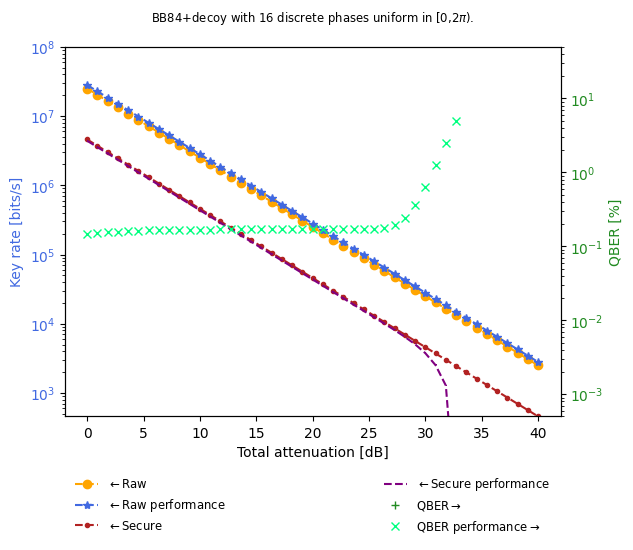

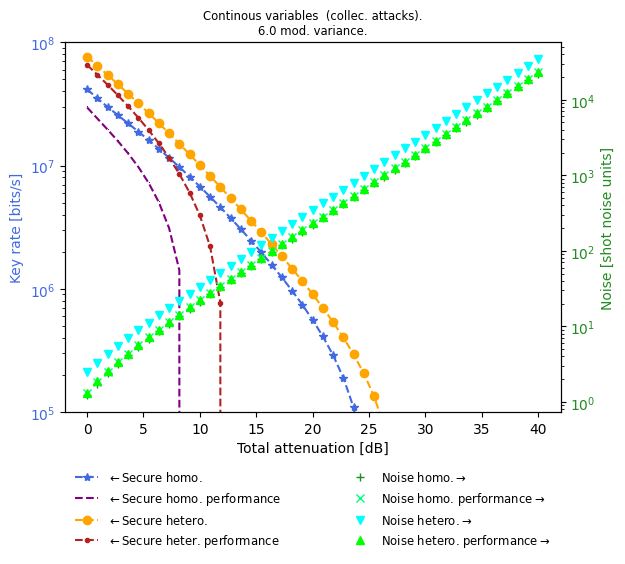

In [ ]:
################################################################################
# General parameters
NumberMeasurementsAlongAttenuationDistance=45 
AttenuationdBforDistance=np.linspace(0.0,40.0,NumberMeasurementsAlongAttenuationDistance) # Inside, the algorithms account for some internal losses, primarly on the detector side

############################################################################
######## DV-QKD - Common configurations
###########################################################################

# Source configuration
SourcePulseRate=100e6 # Pulses trasmitted per Alice per second
Wavelength=1550e-9# Fiber: 1550e-9 and attdB=0.2dB/Km, Free-space: 850e-9 and attdB=0.1dB/Km # [m]
OptPulseDuration=0.01*(1.0/SourcePulseRate)# Duration of the pulse so that the detector gatting is adjusted

# Automatic calculations
EnergySinglePhoton=Hplank*c0/Wavelength
PhotPulse=(OptPulseDuration*LaserPower)/EnergySinglePhoton
SinglePhotonSourceAttdB=10.0*np.log10(PhotPulse/DecoyStatesPhotPulse[0]) # [dB]

# Encoding QKD BB84 protocol
DVQKDprotocol='BB84+decoy'# 'BB84+decoy', 'SARG04+decoy'

# Phase randomization modulator
Nphases=16 # A good value is 10 or more (typically 16, also max value allowed in the scripts). In the system 4 bits will be used, hence Nphases=16
ConfigurationPhases[0]=float(Nphases)

# Polarization/phase modulator
PolarizationSelectionAmplitudeDeviation=np.tan(np.pi/100.0)#1e-2 # Deviation from nominal value (potentially it can account for deviations in polarization or phase states)
ConfigurationPolarizationSelection[0]=PolarizationSelectionAmplitudeDeviation # Meant for deviation

att=np.zeros((int(NumberMeasurementsAlongAttenuationDistance)),dtype=np.float32)
PrecisionElementsRKRDiscretePhase=np.zeros((int(NumberMeasurementsAlongAttenuationDistance)),dtype=np.float32)
PrecisionElementsKeyBitRateLowerBondDiscretePhase=np.zeros((int(NumberMeasurementsAlongAttenuationDistance)),dtype=np.float32)
PrecisionElementsQBERDiscretePhase=np.zeros((int(NumberMeasurementsAlongAttenuationDistance)),dtype=np.float32)
RKRDiscretePhase=np.zeros((int(NumberMeasurementsAlongAttenuationDistance)),dtype=np.float32)
KeyBitRateLowerBondDiscretePhase=np.zeros((int(NumberMeasurementsAlongAttenuationDistance)),dtype=np.float32)
QBERDiscretePhase=np.zeros((int(NumberMeasurementsAlongAttenuationDistance)),dtype=np.float32)
for iIterNumberMeasurementsAlongAttenuationDistance in range(0,int(NumberMeasurementsAlongAttenuationDistance),1):
  # Detector and system performance
  SystemDetectorPerformanceArray[0]=OptPulseDuration*1.0e-5# Y0=Detector darkcount rate per detection window time + stray light that falls in the same wavelength window. 1e-5 # Background yield: detector's dark count rate + other background contributions such as stray light from timing pulses
  SystemDetectorPerformanceArray[4]=50e-12+AttenuationdBforDistance[iIterNumberMeasurementsAlongAttenuationDistance]*(1.0-OptPulseDuration)*100e-12# [s] # Principally from the single photon detectors. It makes qubits fall in different time slots, hence reducing the raw key rate and increasing the background yield. The lasrger the distance the more jitter introduced.
  ###############################################################################
  # BB84+decoys state Realistic performance taking into account standard variations and deviations
  [attAux,PrecisionElementsRKRDiscretePhaseAux,PrecisionElementsKeyBitRateLowerBondDiscretePhaseAux,PrecisionElementsQBERDiscretePhaseAux]=PrecisionElementsTransmissionBB84DecoyStateComputeSKRdiscretephase(SourcePulseRate,SinglePhotonSourceAttdB,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,ConfigurationLaserSource,ConfigurationPulseShaping,ConfigurationPhases,ConfigurationPolarizationSelection,ConfigurationSPlevelAtt,SystemDetectorPerformanceArray,DVQKDprotocol)
  att[iIterNumberMeasurementsAlongAttenuationDistance]=attAux[iIterNumberMeasurementsAlongAttenuationDistance]
  PrecisionElementsRKRDiscretePhase[iIterNumberMeasurementsAlongAttenuationDistance]=PrecisionElementsRKRDiscretePhaseAux[iIterNumberMeasurementsAlongAttenuationDistance]
  PrecisionElementsKeyBitRateLowerBondDiscretePhase[iIterNumberMeasurementsAlongAttenuationDistance]=PrecisionElementsKeyBitRateLowerBondDiscretePhaseAux[iIterNumberMeasurementsAlongAttenuationDistance]
  PrecisionElementsQBERDiscretePhase[iIterNumberMeasurementsAlongAttenuationDistance]=PrecisionElementsQBERDiscretePhaseAux[iIterNumberMeasurementsAlongAttenuationDistance]
  [attAux,RKRDiscretePhaseAux,KeyBitRateLowerBondDiscretePhaseAux,QBERDiscretePhaseAux]=TransmissionBB84DecoyStateComputeSKRdiscretephase(SourcePulseRate,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,Nphases,SystemDetectorPerformanceArray,DVQKDprotocol)
  att[iIterNumberMeasurementsAlongAttenuationDistance]=attAux[iIterNumberMeasurementsAlongAttenuationDistance]
  RKRDiscretePhase[iIterNumberMeasurementsAlongAttenuationDistance]=RKRDiscretePhaseAux[iIterNumberMeasurementsAlongAttenuationDistance]
  KeyBitRateLowerBondDiscretePhase[iIterNumberMeasurementsAlongAttenuationDistance]=KeyBitRateLowerBondDiscretePhaseAux[iIterNumberMeasurementsAlongAttenuationDistance]
  QBERDiscretePhase[iIterNumberMeasurementsAlongAttenuationDistance]=QBERDiscretePhaseAux[iIterNumberMeasurementsAlongAttenuationDistance]
  ###############################################################################

dBatt=-10*np.log10(att)

## Figures
plt.figure()
line1,=plt.plot(dBatt,RKRDiscretePhase,'orange',linestyle='dashed',marker='o')
line2,=plt.plot(dBatt,PrecisionElementsRKRDiscretePhase,'royalblue',linestyle='dashed',marker='*')
line3,=plt.plot(dBatt,KeyBitRateLowerBondDiscretePhase,'firebrick',linestyle='dashed',marker='.')
line4,=plt.plot(dBatt,PrecisionElementsKeyBitRateLowerBondDiscretePhase,'purple',linestyle='dashed',marker=',')
#plt.legend(loc='upper center')
#plt.xscale('log')
plt.ylim(np.max([1e2,KeyBitRateLowerBondDiscretePhase[-1],PrecisionElementsKeyBitRateLowerBondDiscretePhase[-1]]),SourcePulseRate)
plt.yscale('log')
plt.xlabel('Total attenuation [dB]',color='k')
#plt.xlabel('Distance [Km]',color='k')
plt.ylabel('Key rate [bits/s]',color='royalblue')
plt.tick_params(axis="y", labelcolor='royalblue')
plt.twinx()
line5,=plt.plot(dBatt,100.0*QBERDiscretePhase,'forestgreen',linestyle='None',marker='+')
line6,=plt.plot(dBatt,100.0*PrecisionElementsQBERDiscretePhase,'springgreen',linestyle='None',marker='x')
plt.yscale('log')
plt.ylim(np.max([5e-4,np.min([100.0*QBERDiscretePhase[0],100.0*PrecisionElementsQBERDiscretePhase[0]])]),5e1)
plt.tick_params(axis="y", labelcolor='forestgreen')
plt.ylabel('QBER [%]', color='forestgreen')
plt.legend((line1, line2, line3, line4, line5, line6), (r'$\leftarrow$'+'Raw',r'$\leftarrow$'+'Raw performance',r'$\leftarrow$'+'Secure',r'$\leftarrow$'+'Secure performance', 'QBER'+r'$\rightarrow$', 'QBER performance'+r'$\rightarrow$'),bbox_to_anchor=(0, -0.35, 1, 0), loc="lower left", mode="expand", ncol=2,shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.title(DVQKDprotocol+' with '+str(Nphases)+' discrete phases uniform in [$0$,$2\pi$).\n ', fontsize='small')
#plt.savefig('FigTheoreticalBB84decoySKRqber.png', format = 'png', dpi = 600 )
plt.show()

###############################################################################
# Continuous variables - Common configurations
##############################################################################
SourcePulseRate=100e6
Wavelength=1550e-9# Fiber: 1550e-9, Free-space: 850e-9
OptPulseDuration=0.2*(1.0/SourcePulseRate)#s

# Automatic calculations
EnergySinglePhoton=Hplank*c0/Wavelength
PhotPulse=(OptPulseDuration*LaserPower)/EnergySinglePhoton
SinglePhotonSourceAttdB=10.0*np.log10(PhotPulse/DecoyStatesPhotPulse[0]) # [dB]

# Detector and system performance
SystemDetectorPerformanceCVArray[0]=6.0 # modulation variance >1.0. It is important to optimize this value. Experimental study on discretely modulated continuous-variable quantum key distribution
SystemDetectorPerformanceCVArray[4]=SourcePulseRate
SystemDetectorPerformanceCVArray[6]=(SystemDetectorPerformanceCVArray[0]**2)+1e3 # Variance of quadratures without taking the local oscillators's RIN into account [V**2]
SystemDetectorPerformanceCVArray[17]=OptPulseDuration # Pulse duration [s]
SystemDetectorPerformanceCVArray[18]=c0/(n_fiber*Wavelength) #Optical frequency [Hz]
  
AttenuationdBforDistance=np.linspace(0.0,40.0,NumberMeasurementsAlongAttenuationDistance) # Inside, the algorithms account for some internal losses, primarly on the detector side

# Continous variables Realistic performance taking into account variations and deviations
[att,PrecisionElementsKeyBitRateLowerBondContinousVariablesHomoDyne,PrecisionElementsKeyBitRateLowerBondContinousVariablesHeteroDyne,PrecisionElementsNoiseContinousVariablesHomodyne,PrecisionElementsNoiseContinousVariablesHeterodyne,PrecisionElementsQBERHomodyneContinousVariables,PrecisionElementsQBERHeterodyneContinousVariables]=PrecisionElementsTransmissionContinousVariablesComputeSKR(SourcePulseRate,SinglePhotonSourceAttdB,AttenuationdBforDistance,SystemDetectorPerformanceCVArray)
[att,KeyBitRateLowerBondContinousVariablesHomoDyne,KeyBitRateLowerBondContinousVariablesHeteroDyne,NoiseContinousVariablesHomodyne,NoiseContinousVariablesHeterodyne,QBERHomodyneContinousVariables,QBERHeterodyneContinousVariables]=TransmissionContinuousVariablesComputeSKR(SourcePulseRate,AttenuationdBforDistance,SystemDetectorPerformanceCVArray)
###############################################################################

dBatt=-10*np.log10(att)

## Figures
plt.figure()
line1,=plt.plot(dBatt,KeyBitRateLowerBondContinousVariablesHomoDyne,'royalblue',linestyle='dashed',marker='*')
line2,=plt.plot(dBatt,PrecisionElementsKeyBitRateLowerBondContinousVariablesHomoDyne,'purple',linestyle='dashed',marker=',')
line3,=plt.plot(dBatt,KeyBitRateLowerBondContinousVariablesHeteroDyne,'orange',linestyle='dashed',marker='o')
line4,=plt.plot(dBatt,PrecisionElementsKeyBitRateLowerBondContinousVariablesHeteroDyne,'firebrick',linestyle='dashed',marker='.')
#plt.legend(loc='upper center')
#plt.xscale('log')
plt.yscale('log')
plt.ylim(np.max([1e5,KeyBitRateLowerBondContinousVariablesHomoDyne[-1],PrecisionElementsKeyBitRateLowerBondContinousVariablesHomoDyne[-1],KeyBitRateLowerBondContinousVariablesHeteroDyne[-1],PrecisionElementsKeyBitRateLowerBondContinousVariablesHeteroDyne[-1]]),SourcePulseRate)
plt.xlabel('Total attenuation [dB]',color='k')
#plt.xlabel('Distance [Km]',color='k')
plt.ylabel('Key rate [bits/s]',color='royalblue')
plt.tick_params(axis="y", labelcolor='royalblue')
plt.twinx()
line5,=plt.plot(dBatt,NoiseContinousVariablesHomodyne,'forestgreen',linestyle='None',marker='+')
line6,=plt.plot(dBatt,PrecisionElementsNoiseContinousVariablesHomodyne,'springgreen',linestyle='None',marker='x')
line7,=plt.plot(dBatt,NoiseContinousVariablesHeterodyne,'cyan',linestyle='None',marker='v')
line8,=plt.plot(dBatt,PrecisionElementsNoiseContinousVariablesHeterodyne,'lime',linestyle='None',marker='^')
plt.yscale('log')
#plt.ylim(np.max([5e-4,np.min([100.0*NoiseContinousVariables[0],100.0*PrecisionElementsNoiseContinousVariables[0]])]),1e2)
plt.tick_params(axis="y", labelcolor='forestgreen')
plt.ylabel('Noise [shot noise units]', color='forestgreen')
plt.legend((line1, line2, line3, line4, line5, line6, line7, line8), (r'$\leftarrow$'+'Secure homo.',r'$\leftarrow$'+'Secure homo. performance',r'$\leftarrow$'+'Secure hetero.',r'$\leftarrow$'+'Secure heter. performance', 'Noise homo.'+r'$\rightarrow$', 'Noise homo. performance'+r'$\rightarrow$', 'Noise hetero.'+r'$\rightarrow$', 'Noise hetero. performance'+r'$\rightarrow$'),bbox_to_anchor=(0, -0.4, 1, 0), loc="lower left", mode="expand", ncol=2,shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.title('Continous variables  (collec. attacks).\n'+str("{:.1f}".format(SystemDetectorPerformanceCVArray[0]))+' mod. variance.', fontsize='small')
#plt.savefig('FigTheoreticalCVSKRnoise.png', format = 'png', dpi = 600 )
plt.show()


# Further exercises on Quantum Key Distribution using entanglement (E91)
- Run the below script where it is computed the QBER for E91 and BB84 protocols (without noise).
- When there are noises (activate noise flag) present will the E91 QBER be higher or lower compared to BB84-solution? Why?
- Describe advantages and disadvantages of using E91 compared ot BB84.

In [ ]:
###############################################################################
# Example of a Entanglement-based QKD protocol implemented in python
# E91 protocol: https://arxiv.org/pdf/0802.4155.pdf and https://cqi.inf.usi.ch/qic/91_Ekert.pdf
import qiskit
from qiskit.providers.aer import QasmSimulator
import qiskit_aer.noise as noise
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import Statevector
from qiskit import ClassicalRegister,QuantumRegister,QuantumCircuit

NoiseFlag=True
NumberShots=int(2046) # Equivalent to the number of qubits shared

AliceQubitsBB84=np.random.randint(0,2,size=NumberShots)
AliceBasis=np.random.randint(0,2,size=NumberShots)
BobBasis=np.random.randint(0,2,size=NumberShots)
AliceSiftedQubitsBB84=[]
BobSiftedQubitsBB84=[]
AliceSiftedQubitsE91=[]
BobSiftedQubitsE91=[]
QBERBB84=0.0
QBERE91=0.0
############################################################
# Error probabilities
prob_1 = 0.1  # 1-qubit gate
# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['ry'])
#print(noise_model)
#####################################
for iIterRuns in range(0,NumberShots,1):  
  ######################################
  # E91
  # Create a Quantum Register with two qubits
  qr=QuantumRegister(2)
  # Create a Classical Register with two bits
  cr=ClassicalRegister(2)
  # Create a Quantum Circuit using the qr and cr registers
  circuit=QuantumCircuit(qr,cr)
  # Apply a Hadamard gate to the first qubit to put it in superposition
  circuit.h(qr[0])
  # Apply a CNOT gate to entangle the two qubits
  circuit.cx(qr[0],qr[1])
  # Randomly select measurement bases
  if (AliceBasis[iIterRuns]==1 and BobBasis[iIterRuns]==1):
    RotAngle0=np.pi/2.0
    RotAngle1=np.pi/2.0
  elif (AliceBasis[iIterRuns]==0 and BobBasis[iIterRuns]==1):
    RotAngle0=0.0
    RotAngle1=np.pi/2.0
  elif (AliceBasis[iIterRuns]==1 and BobBasis[iIterRuns]==0):
    RotAngle0=np.pi/2.0
    RotAngle1=0.0
  else:
    RotAngle0=0.0
    RotAngle1=0.0
  circuit.ry(RotAngle0,0)
  circuit.ry(RotAngle1,1)
  # Measure the qubits and store the results in the classical register  
  circuit.measure(qr,cr)
  # Initialize the simulator and execute the circuit
  simulator=QasmSimulator()
  if (NoiseFlag):
    job=qiskit.execute(circuit, simulator,noise_model=noise_model,shots=1,memory=True)#,shots=NumberShots,memory=True)
  else:
    job=qiskit.execute(circuit, simulator,shots=1,memory=True)#,shots=NumberShots,memory=True)
  # Get the measurement results from the classical register
  result=job.result()

  #print(result.get_memory()[0])
  if (result.get_memory()[0]=='11'):
    AliceQubitE91=1.0
    BobQubitE91=1.0
  elif (result.get_memory()[0]=='10'):
    AliceQubitE91=1.0
    BobQubitE91=0.0
  elif (result.get_memory()[0]=='01'):
    AliceQubitE91=0.0
    BobQubitE91=1.0
  else: #elif (result.get_memory()[0]=='00'):
    AliceQubitE91=0.0
    BobQubitE91=0.0  
  
  # Sift bits
  if (AliceBasis[iIterRuns]==BobBasis[iIterRuns]):
    AliceSiftedQubitsE91.append(AliceQubitE91)
    BobSiftedQubitsE91.append(BobQubitE91)
    if (AliceQubitE91!=BobQubitE91):
      QBERE91+=1.0
  
  ###########################################################
  # BB84
  # Create a Quantum Register with one qubit
  qr=QuantumRegister(1)
  # Create a Classical Register with one bit
  cr=ClassicalRegister(1)
  # Create a Quantum Circuit using the qr and cr registers
  circuit=QuantumCircuit(qr,cr)
  
  # Prepare Alice QuBit
  #print(f'AliceQubitsBB84[iIterRuns]: {AliceQubitsBB84[iIterRuns]}')
  if (AliceBasis[iIterRuns]==1):
    if (AliceQubitsBB84[iIterRuns]==1):
      state=Statevector([1.0/np.sqrt(2),-1.0/np.sqrt(2)])
    else:
      state=Statevector([1.0/np.sqrt(2),1.0/np.sqrt(2)])
  else:
    if (AliceQubitsBB84[iIterRuns]==1):
      state=Statevector([0.0,1.0])
    else:
      state=Statevector([1.0,0.0])
  
  circuit.initialize(state.data, [0]) # Initialize qubit

  # Randomly select measurement bases  
  if (BobBasis[iIterRuns]==1):
    RotAngle1=-np.pi/2.0
  else:
    RotAngle1=0.0
  circuit.ry(RotAngle1,0)
    
  # Measure the qubits and store the results in the classical register  
  circuit.measure(qr,cr)
  # Initialize the simulator and execute the circuit
  simulator=QasmSimulator()
  if (NoiseFlag):
    job=qiskit.execute(circuit, simulator,noise_model=noise_model,shots=1,memory=True)#,shots=NumberShots,memory=True)
  else:
    job=qiskit.execute(circuit, simulator,shots=1,memory=True)#,shots=NumberShots,memory=True)
  # Get the measurement results from the classical register
  result=job.result()
  #print(result.data(0)['v1'])
  #print(result.get_memory()[0])
  if ((result.get_memory()[0])=='1'):
    BobQubitBB84=1.0
  else: #elif (result.get_memory()[0]=='0'):
    BobQubitBB84=0.0  
  
  # Sift bits
  if (AliceBasis[iIterRuns]==BobBasis[iIterRuns]):
    #print(f'float(AliceQubitsBB84[iIterRuns]): {float(AliceQubitsBB84[iIterRuns])}')
    #print(f'BobQubitBB84: {BobQubitBB84}')
    #print(f'AliceBasis[iIterRuns]: {AliceBasis[iIterRuns]}')
    #print(f'BobBasis[iIterRuns]: {BobBasis[iIterRuns]}')
    AliceSiftedQubitsBB84.append(float(AliceQubitsBB84[iIterRuns]))
    BobSiftedQubitsBB84.append(BobQubitBB84)
    if (float(AliceQubitsBB84[iIterRuns])!=BobQubitBB84):
      #print(f'float(AliceQubitsBB84[iIterRuns]): {float(AliceQubitsBB84[iIterRuns])}')
      #print(f'BobQubitBB84: {BobQubitBB84}')
      QBERBB84+=1.0

QBERE91=QBERE91/float(len(AliceSiftedQubitsE91))
QBERBB84=QBERBB84/float(len(AliceSiftedQubitsBB84))

# Display the shared keys and QBERs
print(f'AliceSiftedQubitsBB84: {AliceSiftedQubitsBB84[0:32]}')
print(f'BobSiftedQubitsBB84: {BobSiftedQubitsBB84[0:32]}')
print(f'AliceSiftedQubitsE91: {AliceSiftedQubitsE91[0:32]}')
print(f'BobSiftedQubitsE91: {BobSiftedQubitsE91[0:32]}')
print(f'QBERE91: {QBERE91:.4f}')
print(f'QBERBB84: {QBERBB84:.4f}')

AliceSiftedQubitsBB84: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]
BobSiftedQubitsBB84: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]
AliceSiftedQubitsE91: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
BobSiftedQubitsE91: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
QBERE91: 0.0439
QBERBB84: 0.0239


# Teleportation exercise

In an experiment, four photon polarization states are randomly teleported.	These states are equivalent to the following qubits:

|0>, |1>, 1/√2(|0>+|1>) and 1/√2(|0>−i|1>). 

 - When Alice and Bob share an entangled state (desactivate FlagNotBellStateShared=False). Which will be the Fidelity?

 - Consider now that Alice and Bob do not share an entangled state but instead share the state |01> (activate FlagNotBellStateShared=True). Study that in this case the range of Fidelities obtained. Describe them.
 
- In this quantum teleportation protocol which is the range of Fidelities attainable?


<IPython.core.display.Latex object>

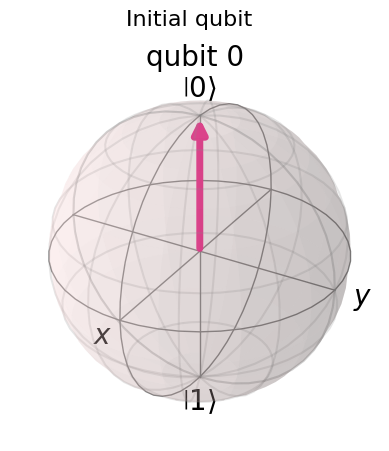

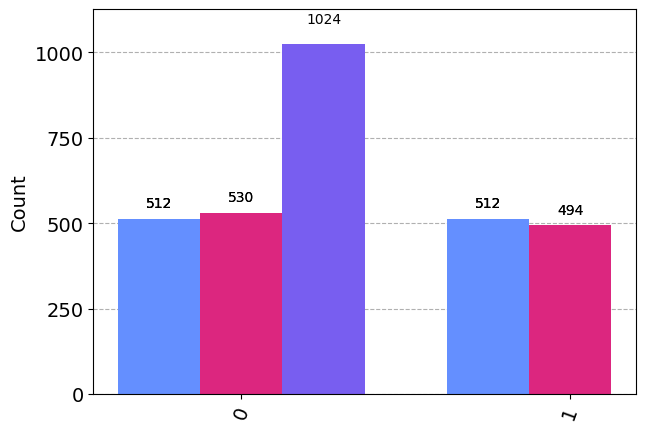

The experimental error rate is: 0.000%
Theoretical Fidelity: 100.00 [%]


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
#from qiskit.ignis.verification import marginal_counts
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

psi=Statevector([1.0,0.0])#Statevector([1.0/np.sqrt(2),-1j*1.0/np.sqrt(2)])#Statevector([1.0,0.0])#Statevector([1.0/np.sqrt(2),1.0/np.sqrt(2)])
FlagNotBellStateShared=False

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
display(plot_bloch_multivector(psi,title='Initial qubit'))

def create_bell_pair(qc, a, b):
  if (FlagNotBellStateShared):
    """Creates a pair |01> in qc using qubits a & b"""
    stateNonEntangled=Statevector([0.0,1.0,0.0,0.0])
    qc.initialize(stateNonEntangled.data, [1,2]) # Initialize qubits
  else:
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

# Let's create our initialization instruction to create |ψ⟩
init_gate = Initialize(psi)
init_gate.label = "init"
# First, let's initialize Alice's q0
teleportation_circuit.append(init_gate, [0])

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
#display(teleportation_circuit.draw())

def alice_gates(qc, psi, a):
  qc.cx(psi, a)
  qc.h(psi)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
#display(teleportation_circuit.draw())

def measure_and_send(qc, a, b):
  """Measures qubits a & b and 'sends' the results to Bob"""
  qc.barrier()
  qc.measure(a,0)
  qc.measure(b,1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
#display(teleportation_circuit.draw())

# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
  # Here we use c_if to control our gates with a classical
  # bit instead of a qubit
  qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
  qc.z(qubit).c_if(crz, 1) # are in the state '1'

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)

## STEP 5
# reverse the initialization process
# Check that the state teleported at the output is the same as at the beggining
inverse_init_gate = init_gate.gates_to_uncompute()
teleportation_circuit.append(inverse_init_gate, [2])

# We can see the inverse_init_gate appearing, labelled 'disentangler' on the circuit diagram. Finally, we measure the third qubit and store the result in the third classical bit:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
teleportation_circuit.add_register(cr_result)
teleportation_circuit.measure(2,2)
#qc.draw()

# and we run our experiment:
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(teleportation_circuit, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
display(plot_histogram(qubit_counts))

if (FlagNotBellStateShared):
  try:
    MarginalCount1=marginal_counts(counts, [2])['1']
    MarginalCount0=marginal_counts(counts, [2])['0']
    if (MarginalCount1<MarginalCount0):
      ExpError=marginal_counts(counts, [2])['1']/(marginal_counts(counts, [2])['0']+marginal_counts(counts, [2])['1'])
    else:
      ExpError=marginal_counts(counts, [2])['0']/(marginal_counts(counts, [2])['0']+marginal_counts(counts, [2])['1'])
  except:
    ExpError=1.0
else:
  ExpError=0.0
print(f"The experimental error rate is: {ExpError*100.0:.3f}%")

Ftheor=1.0-ExpError*0.5
print(f'Theoretical Fidelity: {Ftheor*100.0:.2f} [%]')

# Wrap-up of Probability errors and Fidelity

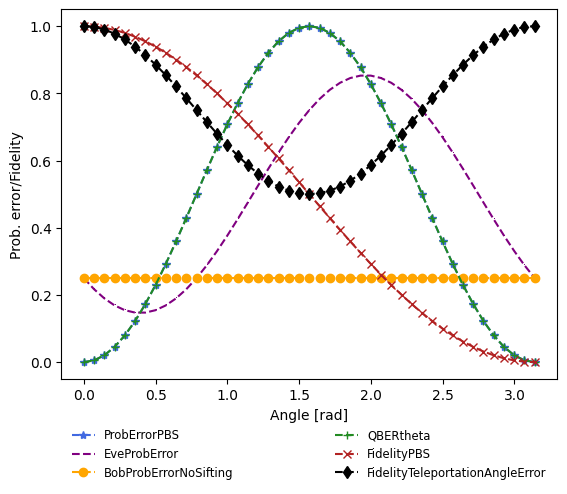

In [ ]:
##############################################################################
# Relation of Probability errors, QBER, Fidelities with the the rotation of the measurement basis \theta
NcalcAngle=45
MaxAngle=np.pi
AnglesScan=np.linspace(0,MaxAngle,NcalcAngle)

ProbErrorPBS=1.0-np.cos(AnglesScan)**2
EveProbError=0.25*((1.0-np.cos(2.0*AnglesScan))+(1.0-np.sin(2.0*AnglesScan))) # Error probability when Eve is randomly changing basis (it is minimized to 14.64% when theta=np.pi/8 - Breidbart basis)
BobProbErrorNoSifting=0.25*((1.0-np.cos(2.0*AnglesScan)**2)+(1.0-np.sin(2.0*AnglesScan)**2)) # Error probability when Bob is randomly changes basis (before key sifting)
QBERtheta=1.0-np.cos(AnglesScan)**2 # Error probability equivalent to Bob when doing sifting
FidelityPBS=1.0-np.sin(AnglesScan/2.0)**2# Angle is half, because at np.pi/2.0 its like at half place between the two states
FidelityTeleportationAngleError=1.0-ProbErrorPBS/2.0

plt.figure()
line1,=plt.plot(AnglesScan,ProbErrorPBS,'royalblue',linestyle='dashed',marker='*')
line2,=plt.plot(AnglesScan,EveProbError,'purple',linestyle='dashed',marker=',')
line3,=plt.plot(AnglesScan,BobProbErrorNoSifting,'orange',linestyle='dashed',marker='o')
line4,=plt.plot(AnglesScan,QBERtheta,'forestgreen',linestyle='dashed',marker='+')
line5,=plt.plot(AnglesScan,FidelityPBS,'firebrick',linestyle='dashed',marker='x')
line6,=plt.plot(AnglesScan,FidelityTeleportationAngleError,'black',linestyle='dashed',marker='d')
plt.legend((line1, line2, line3, line4, line5, line6), ('ProbErrorPBS','EveProbError','BobProbErrorNoSifting','QBERtheta','FidelityPBS','FidelityTeleportationAngleError'),bbox_to_anchor=(0, -0.3, 1, 0), loc="lower left", mode="expand", ncol=2,shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.xlabel('Angle [rad]',color='k')
plt.ylabel('Prob. error/Fidelity',color='k')
plt.show()

####################################################
# Relevant trigonometric relations
# cos(theta)**2+sin(theta)**2=1
# sin(theta)**2=0.5*(1-cos(2theta))
# cos(theta)**2=0.5*(1+cos(2theta))